# This notebook

In this notebook, we exlore the co-occurrence of keywords across a set of temporal subsets to detect patterns of change in co-occurrence.

Temporal subsets are defined according to key events in the timeline of covid19 pandemic in the UK:

- up to 23 March 2020 (excluded): pre-lockdown
- 23 March to 10 May 2020: strict lockdown
- 11 May 2020 onwards: post- strict lockdown (lockdown eases)

Note that there are additional dates that we may have considered (e.g., 14 March 2020 "herd immunity" approach is mentioned, 13 June 2020 "social bubbles" introduced, 15 June non-essential shops reopen) but that would create temporal sub-windows with little amount of data.

We will:

- [keyword class] Classify keywords according to their normalised corpus frequency and relative document frequency values, for each of the three main time windows
- [co-occurrence] For each temporal window, calculate the co-occurrence of keyword pairs as Positive Pointwise Mutual Information and Simpson coefficient
- Identify changes in keyword class and keyword co-occurrence across the temporal windows.
- Create networks of keyword co-occurrences for each of the three temporal windows and compare network and nodes characteristics across the three.


## Settings

In [1]:
import os

In [2]:
import numpy as np

In [3]:
from math import log2

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import networkx as nx
from operator import itemgetter

In [6]:
%matplotlib inline

In [7]:
from src.news_media.get_keywords_trend import *

/Users/alessiatosi/DS_projects/behavioural-sci-perception/docs/ext/keywords.yaml has been successfully loaded as a dict
/Users/alessiatosi/DS_projects/behavioural-sci-perception/docs/ext/subkw_to_kw_map.yaml has been successfully loaded as a dict


In [8]:
pd.set_option('display.max_colwidth', None)

The config file

In [9]:
CONFIG.keys()

dict_keys(['NgramRange', 'Actors', 'BehavSci', 'Behav_ins', 'Behav_chan', 'Behav_pol', 'Behav_anal', 'Psych', 'Econ_behav', 'Econ_irrational', 'Nudge', 'Nudge_choice', 'Nudge_pater', 'Covid', 'Fatigue', 'Immunity'])

In [10]:
DIR_DATA = os.environ.get("DIR_DATA_INTERIM")

In [11]:
DIR_DATA_EXTRA = os.environ.get("DIR_DATA_EXTRA")

In [12]:
# prominence
term_freqs_nm = "kword_rawfreq.csv"
doc_freqs_nm = "kword_yn_occurrence.csv"

In [13]:
# keywords to be excluded because of low frequency in the corpus or decided not important
EXCLUDE_KWORDS = ['behav_insight', 'behavioural_economist', 'behav_analysis', 'chater', 'american_behav_scientists']

In [14]:
# we kept in some important words that though are not keywords
NONKEYWORDS = ['herd_immunity', 'behavioural_fatigue']

## Import UK's news articles

In [15]:
doc_freqs = pd.read_csv(os.path.join(DIR_DATA, doc_freqs_nm))

In [16]:
kword_rawfreqs = pd.read_csv(os.path.join(DIR_DATA, term_freqs_nm))

## Remove low frequency keywords & non-keywords

In [17]:
doc_freqs.drop(EXCLUDE_KWORDS, axis=1, inplace=True)

In [18]:
kword_rawfreqs.drop(EXCLUDE_KWORDS, axis=1, inplace=True)

In [19]:
doc_freqs.drop(NONKEYWORDS, axis=1, inplace=True)

In [20]:
kword_rawfreqs.drop(NONKEYWORDS, axis=1, inplace=True)

## Group data into time windows

According to dates: before 23 March, from 23 March to 10 May, from 11 May onwards.

In [21]:
kword_rawfreqs['pub_date_dt'] = [datetime.strptime(pub_d, '%Y-%m-%d') for pub_d in kword_rawfreqs.pub_date_dt]


In [22]:
doc_freqs['pub_date_dt'] = [datetime.strptime(pub_d, '%Y-%m-%d') for pub_d in doc_freqs.pub_date_dt]

In [23]:
def label_weeks(date):
    """Assigns and labels weeks to a time window."""
    if date <= datetime.strptime("2020-03-22", '%Y-%m-%d'):
        return "before-lockdown"
    if (date > datetime.strptime("2020-03-22", '%Y-%m-%d')) and (date <= datetime.strptime("2020-05-10", '%Y-%m-%d')):
        return "lockdown"
    if date > datetime.strptime("2020-05-10", '%Y-%m-%d'):
        return "post-lockdown"
    

In [24]:
kword_rawfreqs["time_window"] = kword_rawfreqs.pub_date_dt.apply(label_weeks)

In [25]:
doc_freqs["time_window"] = doc_freqs.pub_date_dt.apply(label_weeks)

In [26]:
doc_freqs.set_index([doc_freqs.index, doc_freqs.pub_date_dt, doc_freqs.article_id, 
                     doc_freqs.word_count, doc_freqs.time_window], inplace=True, drop=True)


In [27]:
doc_freqs.drop(['pub_date_dt', 'Unnamed: 0', 'article_id', 'word_count', 'time_window'], inplace=True, axis=1)

In [28]:
kword_rawfreqs.set_index([kword_rawfreqs.index, kword_rawfreqs.pub_date_dt, kword_rawfreqs.article_id, kword_rawfreqs.word_count,  
                          kword_rawfreqs.time_window], inplace=True, drop=True)

In [29]:
kword_rawfreqs.drop(['pub_date_dt', 'Unnamed: 0', 'article_id', 'word_count', 'time_window'], inplace=True, axis=1)

### Count of keyword occurrences devided by total word count in each time window.

In [30]:
kword_rawfreqs_agg = kword_rawfreqs.reset_index(['article_id', 'word_count']).groupby('time_window').agg(
    word_count=('word_count', 'sum')).merge(
                        kword_rawfreqs.groupby('time_window').sum(),
                        on='time_window')

In [31]:
kword_rawfreqs_agg

word_count  behav_change  behav_econ  behav_insights_team  \
time_window                                                                  
before-lockdown       44031             5           7                   67   
lockdown              73097            25          18                   50   
post-lockdown         66540            15          11                   17   

                 behav_science  behav_scientist  halpern  michie  nudge  \
time_window                                                               
before-lockdown             89               12       36      44     44   
lockdown                   175               34       32      82     49   
post-lockdown              160               22       15      80     20   

                 psychologist  psychology  spi-b  
time_window                                       
before-lockdown            14          33      4  
lockdown                   30          64     85  
post-lockdown              28          68     77

In [32]:
kword_agg_nkf = kword_rawfreqs_agg.iloc[:, 1:].div(kword_rawfreqs_agg.word_count, axis=0)

In [33]:
kword_agg_nkf_long = pd.melt(
                    kword_agg_nkf.reset_index(),
                    id_vars=['time_window'],
                    var_name='kword',
                    value_name='nkf')

In [34]:
kword_agg_nkf_long.pivot(index='kword', columns='time_window', values='nkf')

time_window          before-lockdown  lockdown  post-lockdown
kword                                                        
behav_change                0.000114  0.000342       0.000225
behav_econ                  0.000159  0.000246       0.000165
behav_insights_team         0.001522  0.000684       0.000255
behav_science               0.002021  0.002394       0.002405
behav_scientist             0.000273  0.000465       0.000331
halpern                     0.000818  0.000438       0.000225
michie                      0.000999  0.001122       0.001202
nudge                       0.000999  0.000670       0.000301
psychologist                0.000318  0.000410       0.000421
psychology                  0.000749  0.000876       0.001022
spi-b                       0.000091  0.001163       0.001157

## Keyword document frequency per time windows

In [35]:
doc_freqs_agg = doc_freqs.reset_index(['article_id']).groupby('time_window').agg(
    article_count=('article_id', 'count')).merge(
                        doc_freqs.groupby('time_window').sum(),
                        on='time_window')

In [36]:
doc_freqs_agg

article_count  behav_change  behav_econ  behav_insights_team  \
time_window                                                                     
before-lockdown            157             3           6                   38   
lockdown                   266            23          15                   29   
post-lockdown              224            15          11                   10   

                 behav_science  behav_scientist  halpern  michie  nudge  \
time_window                                                               
before-lockdown             73               12       24      12     26   
lockdown                   131               33       16      47     26   
post-lockdown              117               21        7      49     10   

                 psychologist  psychology  spi-b  
time_window                                       
before-lockdown            10          27      2  
lockdown                   27          52     34  
post-lockdown              26          42     45

In [37]:
kword_agg_rdf = doc_freqs_agg.iloc[:, 1:].div(doc_freqs_agg.article_count, axis=0)

In [38]:
kword_rdf_agg_long = pd.melt(
                    kword_agg_rdf.reset_index(),
                    id_vars=['time_window'],
                    var_name='kword',
                    value_name='rdf')

In [39]:
kword_rdf_agg_long.pivot(index='kword', columns='time_window', values='rdf')

time_window          before-lockdown  lockdown  post-lockdown
kword                                                        
behav_change                0.019108  0.086466       0.066964
behav_econ                  0.038217  0.056391       0.049107
behav_insights_team         0.242038  0.109023       0.044643
behav_science               0.464968  0.492481       0.522321
behav_scientist             0.076433  0.124060       0.093750
halpern                     0.152866  0.060150       0.031250
michie                      0.076433  0.176692       0.218750
nudge                       0.165605  0.097744       0.044643
psychologist                0.063694  0.101504       0.116071
psychology                  0.171975  0.195489       0.187500
spi-b                       0.012739  0.127820       0.200893

## Median normalised keyword frequency

Here we look at which keywords' frequency was above the median frequency of all keywords to get an indication of keywords' relative prominance in the press.

Note that the `median nkf` is calculated only considering the keywords' nkf values and not all words' or all nouns' nkf. So the meaning of High Frequent and Low Frequent keywords - i.e., above the median and below the median frequently keywords - must be interpreted relatively to the use of keywords only and not to all words or nouns used in the articles.

An alternative apporach would be to set a threhold value or calculate the normalised word frequencies for all words (or nouns) in the articles and its median (more time consuming as it will require re-do some pre-existing steps).

In [40]:
# nkf_medians = kword_agg_nkf_long.groupby('time_window').agg({'nkf':'median'})
# print(nkf_medians)

In [41]:
# thanks to "transformation"
# kword_agg_nkf_long['above_median'] = kword_agg_nkf_long['nkf'] - kword_agg_nkf_long.groupby('time_window')['nkf'].transform('median') > 0

In [42]:
nkf_median = kword_agg_nkf_long.nkf.median()
kword_agg_nkf_long['nkf_above_median'] = kword_agg_nkf_long['nkf'] - nkf_median > 0

Freuqnecy above keywords' median frequency?

In [43]:
kword_agg_nkf_long.pivot(index='kword', columns='time_window', values='nkf_above_median')

time_window          before-lockdown  lockdown  post-lockdown
kword                                                        
behav_change                   False     False          False
behav_econ                     False     False          False
behav_insights_team             True      True          False
behav_science                   True      True           True
behav_scientist                False     False          False
halpern                         True     False          False
michie                          True      True           True
nudge                           True      True          False
psychologist                   False     False          False
psychology                      True      True           True
spi-b                          False      True           True

In [44]:
truthvalue2type_dict = {
    False: "low",
    True: "high"
}

In [45]:
kword_agg_nkf_long["nkf_type"] = kword_agg_nkf_long.nkf_above_median.apply(lambda row: truthvalue2type_dict.get(row))

### Which keywords have high vs low (above vs below median) normalised corpus frequency in the two time windows? 

In [46]:
kword_agg_nkf_long.groupby(['time_window', 'nkf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='time_window', columns='nkf_type')['kwords']

nkf_type                                                                             high  \
time_window                                                                                 
before-lockdown  [behav_insights_team, behav_science, halpern, michie, nudge, psychology]   
lockdown           [behav_insights_team, behav_science, michie, nudge, psychology, spi-b]   
post-lockdown                                  [behav_science, michie, psychology, spi-b]   

nkf_type                                                                                                    low  
time_window                                                                                                      
before-lockdown                                [behav_change, behav_econ, behav_scientist, psychologist, spi-b]  
lockdown                                     [behav_change, behav_econ, behav_scientist, halpern, psychologist]  
post-lockdown    [behav_change, behav_econ, behav_insights_team, behav_scientist, halpern, nudge, psychologist]

### How has a keyword's corpus frequency changed across time windows?

In [47]:
kword_agg_nkf_long.pivot(index='kword', columns='time_window')['nkf_type']

time_window         before-lockdown lockdown post-lockdown
kword                                                     
behav_change                    low      low           low
behav_econ                      low      low           low
behav_insights_team            high     high           low
behav_science                  high     high          high
behav_scientist                 low      low           low
halpern                        high      low           low
michie                         high     high          high
nudge                          high     high           low
psychologist                    low      low           low
psychology                     high     high          high
spi-b                           low     high          high

The lack of change for most keywords must be partially explained by the fact that high vs low are defined with respect to the keywords' median keyword frequency rather than the median frequency calculated from all words' frequencies.

## Median relative document frequency by time window

This is the same but looking at keywords' document frequency.

In [48]:
rdf_median = kword_rdf_agg_long.rdf.median()

In [49]:
kword_rdf_agg_long['rdf_above_median'] = kword_rdf_agg_long['rdf'] - rdf_median > 0

In [50]:
kword_rdf_agg_long.pivot(index='kword', columns='time_window')['rdf_above_median']

time_window          before-lockdown  lockdown  post-lockdown
kword                                                        
behav_change                   False     False          False
behav_econ                     False     False          False
behav_insights_team             True      True          False
behav_science                   True      True           True
behav_scientist                False      True          False
halpern                         True     False          False
michie                         False      True           True
nudge                           True     False          False
psychologist                   False     False           True
psychology                      True      True           True
spi-b                          False      True           True

In [51]:
kword_rdf_agg_long["rdf_type"] = kword_rdf_agg_long.rdf_above_median.apply(lambda row: truthvalue2type_dict.get(row))

In [52]:
kword_rdf_agg_long.pivot(index='kword', columns='time_window')['rdf_type']

time_window         before-lockdown lockdown post-lockdown
kword                                                     
behav_change                    low      low           low
behav_econ                      low      low           low
behav_insights_team            high     high           low
behav_science                  high     high          high
behav_scientist                 low     high           low
halpern                        high      low           low
michie                          low     high          high
nudge                          high      low           low
psychologist                    low      low          high
psychology                     high     high          high
spi-b                           low     high          high

### Which keywords have high vs low (above vs below median) relative doc frequency in the two time windows? 

In [53]:
kword_rdf_agg_long.groupby(['time_window', 'rdf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='time_window', columns='rdf_type')['kwords']

rdf_type                                                                                     high  \
time_window                                                                                         
before-lockdown                  [behav_insights_team, behav_science, halpern, nudge, psychology]   
lockdown         [behav_insights_team, behav_science, behav_scientist, michie, psychology, spi-b]   
post-lockdown                            [behav_science, michie, psychologist, psychology, spi-b]   

rdf_type                                                                                      low  
time_window                                                                                        
before-lockdown          [behav_change, behav_econ, behav_scientist, michie, psychologist, spi-b]  
lockdown                                 [behav_change, behav_econ, halpern, nudge, psychologist]  
post-lockdown    [behav_change, behav_econ, behav_insights_team, behav_scientist, halpern, nudge]

In [54]:
kword_rdf_agg_long.pivot(index='kword', columns='time_window')['rdf_type']

time_window         before-lockdown lockdown post-lockdown
kword                                                     
behav_change                    low      low           low
behav_econ                      low      low           low
behav_insights_team            high     high           low
behav_science                  high     high          high
behav_scientist                 low     high           low
halpern                        high      low           low
michie                          low     high          high
nudge                          high      low           low
psychologist                    low      low          high
psychology                     high     high          high
spi-b                           low     high          high

## Combine the two datasets together

We can classify keywords according to their normalised corpus frequency and relative document frequency values.

For the three main time sub-windows we are looking at (pre-, during-, after- strict lockdown), we can then classify keywords into one of four categories:


- Keywords whose document frequency and term frequency are both above their median:
    Major keyword - central to the narrative of a group of documents)

- Keywords whose document frequency and term frequency are both below their median:
    Minor keyword - Specific to some articles (local) and marginal

- Keywords with below-median document frequency but above-median term frequency
    Keyword discussed locally (central to one or few articles)

- Keywords with above-median document frequency but below-median term frequency
    Supplementary keyword (not in main narrative) but consistent (with media spread)


In [55]:
kword_agg_nkf_rdf = kword_agg_nkf_long.merge(kword_rdf_agg_long, on = ['time_window', 'kword'])

Let's take a look

Document frequency in the columns, term frequency in the rows

#### Pre-lockdown

In [56]:
kword_agg_nkf_rdf[kword_agg_nkf_rdf.time_window == "before-lockdown"].groupby(['nkf_type', 'rdf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='nkf_type', columns='rdf_type')['kwords']

rdf_type                                                              high  \
nkf_type                                                                     
high      [behav_insights_team, behav_science, halpern, nudge, psychology]   
low                                                                    NaN   

rdf_type                                                               low  
nkf_type                                                                    
high                                                              [michie]  
low       [behav_change, behav_econ, behav_scientist, psychologist, spi-b]

#### Lockdown

In [57]:
kword_agg_nkf_rdf[kword_agg_nkf_rdf.time_window == "lockdown"].groupby(['nkf_type', 'rdf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='nkf_type', columns='rdf_type')['kwords']

rdf_type                                                             high  \
nkf_type                                                                    
high      [behav_insights_team, behav_science, michie, psychology, spi-b]   
low                                                     [behav_scientist]   

rdf_type                                                low  
nkf_type                                                     
high                                                [nudge]  
low       [behav_change, behav_econ, halpern, psychologist]

Does not seem to provide great insights as keywords which have an above-median normalised keyword frequency also have an above-average relative document frequency.

#### Post-Lockdown

In [58]:
kword_agg_nkf_rdf[kword_agg_nkf_rdf.time_window == "post-lockdown"].groupby(['nkf_type', 'rdf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='nkf_type', columns='rdf_type')['kwords']

rdf_type                                        high  \
nkf_type                                               
high      [behav_science, michie, psychology, spi-b]   
low                                   [psychologist]   

rdf_type                                                                               low  
nkf_type                                                                                    
high                                                                                   NaN  
low       [behav_change, behav_econ, behav_insights_team, behav_scientist, halpern, nudge]

# Co-occurrence

## Separate before-lockdown vs lockdown data

In [59]:
doc_freqs_before = doc_freqs[doc_freqs.index.get_level_values('time_window').isin(['before-lockdown'])]
doc_freqs_lock = doc_freqs[doc_freqs.index.get_level_values('time_window').isin(['lockdown'])]
doc_freqs_post = doc_freqs[doc_freqs.index.get_level_values('time_window').isin(['post-lockdown'])]

kword_rawfreqs_before = kword_rawfreqs[kword_rawfreqs.index.get_level_values('time_window').isin(['before-lockdown'])]
kword_rawfreqs_lock = kword_rawfreqs[kword_rawfreqs.index.get_level_values('time_window').isin(['lockdown'])]
kword_rawfreqs_post = kword_rawfreqs[kword_rawfreqs.index.get_level_values('time_window').isin(['post-lockdown'])]

# Dice coefficient

We define co-occurrence as two keywords appearing in the same article, regardless of how many times each appears in the articles. So our measure of co-occurrence is based on document co-occurrence.

We normalise co-occurrence by using the Dice coefficient, which is a used in corpus linguistics and should not inflate the importance of co-occurrence for keywords with a very low appearence count in the corpus. That is, words that are frequent by themselves tend to have frequent relations to other words. Other metrics like Dice coefficiet, mutual information orlog-likelihood ratio, will tell if a relation is more frequent than one would expect given the frequency of the individual words.

- The co-occurrence relationship between any two keywords was expressed by the Dice coefficient in information theory (pseudocode shown below), describing the strength of association between these two keywords. 
- The main reason for choosing mutual information instead of selecting the number of frequent words could be analysed by the following process, ADD
- Note that the co-occurrence of two keywords can be relatively small, but if they almost always appeared at the same time, their Dice coefficient will be higher, as they were considered to be in a co-occurrence relationship.

Ref: 
https://onlinelibrary.wiley.com/doi/pdf/10.1002/ecj.10347

https://www.aclweb.org/anthology/C12-2049.pdf

https://www.aclweb.org/anthology/J05-4002.pdf

`Dice coefficient = (2 * count(w1, w2)) / (count(w1) + count(w2))`

The number of co-occurrences multiplied by two divided by the sum of the two keywords' individual document occurrences.

E.g., Given the following document occurrences and co-occurrence: keyword A : 10, keyword B : 6, co-occurrence :4,
the Dice coefficient representing the co-occurrence of A and B is:

In [60]:
2*4/(10+6)

0.5

Compared this to a case where keyword A : 10, keyword B : 6, co-occurrence : 6

In [61]:
2*6/(10+6)

0.75

In [62]:
from itertools import combinations

def calc_dice(yn_occurence_data, kwords_list, prefix=""):
    # keyword document occurrence
    kword_docfreqs = yn_occurence_data.sum(axis=0)
    # keywords co-occurrence matrix
    kword_cooccurences = yn_occurence_data.values.T.dot(yn_occurence_data.values)
    np.fill_diagonal(kword_cooccurences, 0)
    kwords = yn_occurence_data.columns
    kword_cooccurences = pd.DataFrame(kword_cooccurences, index=kwords, columns=kwords)
    kword_cooccurences = kword_cooccurences.stack()
    
    
    def _dice(w1, w2):
        # print(f"{w1}: {kword_docfreqs[w1]}")
        # print(f"{w2}: {kword_docfreqs[w2]}")
        # print(f"coocc: {kword_cooccurences[w1][w2]}")
        try:
            return (2 * kword_cooccurences[w1][w2]) / (kword_docfreqs[w1] + kword_docfreqs[w2])
        except (ValueError, ZeroDivisionError) as err: # one of the two individual counts are 0
            return np.nan
        
    def dice(kwords_list: list) -> list:
        coefs = []
        for pair in combinations(kwords_list, r=2):
            coefs.append((*pair, _dice(*pair), kword_cooccurences[pair[0]][pair[1]], kword_docfreqs[pair[0]], kword_docfreqs[pair[1]] ))
        return coefs
    
    dices = dice(kwords_list=kwords_list)
    dices_df = pd.DataFrame(dices, columns=['source', 'target', f'{prefix}_weight', f'{prefix}_co-occ', f'{prefix}_source_docfreq', f'{prefix}_target_docfreq'])
    
    return dices_df
    

In [63]:
kwords = doc_freqs_before.columns.tolist()

In [64]:
before_dice_coefs = calc_dice(yn_occurence_data=doc_freqs_before, kwords_list=kwords, prefix="bef")

In [65]:
lock_dice_coefs = calc_dice(yn_occurence_data=doc_freqs_lock, kwords_list=kwords, prefix="lock")

In [66]:
post_dice_coefs = calc_dice(yn_occurence_data=doc_freqs_post, kwords_list=kwords, prefix="post")

## How has co-occurrence (as Dice coefficient) evolved before vs. during vs. post lockdown

CHECK : is Dice coefficient a fair representation?

#### Before

In [67]:
before_dice_coefs.sort_values('bef_weight', ascending=False)[:30]

source               target  bef_weight  bef_co-occ  \
21  behav_insights_team              halpern    0.709677          22   
47               michie           psychology    0.564103          11   
5          behav_change               michie    0.400000           3   
35      behav_scientist               michie    0.333333           4   
38      behav_scientist           psychology    0.307692           6   
16           behav_econ         psychologist    0.250000           2   
32        behav_science           psychology    0.220000          11   
52         psychologist           psychology    0.216216           4   
8          behav_change           psychology    0.200000           3   
50                nudge           psychology    0.188679           5   
23  behav_insights_team                nudge    0.187500           6   
15           behav_econ                nudge    0.187500           3   
46               michie         psychologist    0.181818           2   
7          behav_change         psychologist    0.153846           1   
19  behav_insights_team        behav_science    0.126126           7   
24  behav_insights_team         psychologist    0.125000           3   
25  behav_insights_team           psychology    0.123077           4   
17           behav_econ           psychology    0.121212           2   
30        behav_science                nudge    0.121212           6   
49                nudge         psychologist    0.111111           2   
29        behav_science               michie    0.094118           4   
41              halpern                nudge    0.080000           2   
6          behav_change                nudge    0.068966           1   
42              halpern         psychologist    0.058824           1   
45               michie                nudge    0.052632           1   
2          behav_change        behav_science    0.052632           2   
27        behav_science      behav_scientist    0.047059           2   
10           behav_econ  behav_insights_team    0.045455           1   
28        behav_science              halpern    0.041237           2   
43              halpern           psychology    0.039216           1   

    bef_source_docfreq  bef_target_docfreq  
21                  38                  24  
47                  12                  27  
5                    3                  12  
35                  12                  12  
38                  12                  27  
16                   6                  10  
32                  73                  27  
52                  10                  27  
8                    3                  27  
50                  26                  27  
23                  38                  26  
15                   6                  26  
46                  12                  10  
7                    3                  10  
19                  38                  73  
24                  38                  10  
25                  38                  27  
17                   6                  27  
30                  73                  26  
49                  26                  10  
29                  73                  12  
41                  24                  26  
6                    3                  26  
42                  24                  10  
45                  12                  26  
2                    3                  73  
27                  73                  12  
10                   6                  38  
28                  73                  24  
43                  24                  27

### During

In [68]:
lock_dice_coefs.sort_values('lock_weight', ascending=False)[:30]

source           target  lock_weight  lock_co-occ  \
21  behav_insights_team          halpern     0.622222           14   
5          behav_change           michie     0.514286           18   
23  behav_insights_team            nudge     0.290909            8   
32        behav_science       psychology     0.273224           25   
47               michie       psychology     0.242424           12   
52         psychologist       psychology     0.202532            8   
33        behav_science            spi-b     0.193939           16   
41              halpern            nudge     0.190476            4   
54           psychology            spi-b     0.186047            8   
42              halpern     psychologist     0.186047            4   
24  behav_insights_team     psychologist     0.178571            5   
31        behav_science     psychologist     0.164557           13   
46               michie     psychologist     0.162162            6   
8          behav_change       psychology     0.160000            6   
50                nudge       psychology     0.153846            6   
30        behav_science            nudge     0.152866           12   
49                nudge     psychologist     0.150943            4   
19  behav_insights_team    behav_science     0.150000           12   
17           behav_econ       psychology     0.149254            5   
15           behav_econ            nudge     0.146341            3   
36      behav_scientist            nudge     0.135593            4   
37      behav_scientist     psychologist     0.133333            4   
29        behav_science           michie     0.123596           11   
2          behav_change    behav_science     0.116883            9   
25  behav_insights_team       psychology     0.098765            4   
27        behav_science  behav_scientist     0.097561            8   
28        behav_science          halpern     0.095238            7   
38      behav_scientist       psychology     0.094118            4   
7          behav_change     psychologist     0.080000            2   
48               michie            spi-b     0.074074            3   

    lock_source_docfreq  lock_target_docfreq  
21                   29                   16  
5                    23                   47  
23                   29                   26  
32                  131                   52  
47                   47                   52  
52                   27                   52  
33                  131                   34  
41                   16                   26  
54                   52                   34  
42                   16                   27  
24                   29                   27  
31                  131                   27  
46                   47                   27  
8                    23                   52  
50                   26                   52  
30                  131                   26  
49                   26                   27  
19                   29                  131  
17                   15                   52  
15                   15                   26  
36                   33                   26  
37                   33                   27  
29                  131                   47  
2                    23                  131  
25                   29                   52  
27                  131                   33  
28                  131                   16  
38                   33                   52  
7                    23                   27  
48                   47                   34

#### Post

In [69]:
post_dice_coefs.sort_values('post_weight', ascending=False)[:30]

source           target  post_weight  post_co-occ  \
21  behav_insights_team          halpern     0.588235            5   
5          behav_change           michie     0.468750           15   
47               michie       psychology     0.351648           16   
54           psychology            spi-b     0.344828           15   
33        behav_science            spi-b     0.259259           21   
32        behav_science       psychology     0.251572           20   
46               michie     psychologist     0.240000            9   
41              halpern            nudge     0.235294            2   
29        behav_science           michie     0.216867           18   
8          behav_change       psychology     0.210526            6   
23  behav_insights_team            nudge     0.200000            2   
7          behav_change     psychologist     0.195122            4   
31        behav_science     psychologist     0.181818           13   
48               michie            spi-b     0.170213            8   
49                nudge     psychologist     0.166667            3   
50                nudge       psychology     0.153846            4   
52         psychologist       psychology     0.147059            5   
35      behav_scientist           michie     0.142857            5   
53         psychologist            spi-b     0.140845            5   
20  behav_insights_team  behav_scientist     0.129032            2   
37      behav_scientist     psychologist     0.127660            3   
38      behav_scientist       psychology     0.126984            4   
27        behav_science  behav_scientist     0.115942            8   
3          behav_change  behav_scientist     0.111111            2   
9          behav_change            spi-b     0.100000            3   
30        behav_science            nudge     0.078740            5   
2          behav_change    behav_science     0.075758            5   
17           behav_econ       psychology     0.075472            2   
34      behav_scientist          halpern     0.071429            1   
36      behav_scientist            nudge     0.064516            1   

    post_source_docfreq  post_target_docfreq  
21                   10                    7  
5                    15                   49  
47                   49                   42  
54                   42                   45  
33                  117                   45  
32                  117                   42  
46                   49                   26  
41                    7                   10  
29                  117                   49  
8                    15                   42  
23                   10                   10  
7                    15                   26  
31                  117                   26  
48                   49                   45  
49                   10                   26  
50                   10                   42  
52                   26                   42  
35                   21                   49  
53                   26                   45  
20                   10                   21  
37                   21                   26  
38                   21                   42  
27                  117                   21  
3                    15                   21  
9                    15                   45  
30                  117                   10  
2                    15                  117  
17                   11                   42  
34                   21                    7  
36                   21                   10

Merge the coefficients from the three time blocks to compare them more easily

In [70]:
dice_coefs = before_dice_coefs.merge(lock_dice_coefs, how='outer', 
                                                           on = ['source', 'target']).merge(post_dice_coefs, how='outer', on = ['source', 'target']) 
                                   

In [71]:
#dice_coefs[['source', 'target', 'bef_weight', 'lock_weight', 'post_weight']][40:100]

### Top 10 co-occurrent keyword pairs in each time window and how their co-occurrence has changed across the three time blocks

Here we look at the 10 pairs of keyword with the highest Dice coefficients in each of the three time windows, and see how their co-occurrence (as Dice coefficient) has evolved across the three periods.

In [72]:
before_top10_coocurring_pairs = before_dice_coefs.sort_values('bef_weight', ascending=False)[:10].copy()

In [73]:
lock_top10_coocurring_pairs = lock_dice_coefs.sort_values('lock_weight', ascending=False)[:10].copy()

In [74]:
post_top10_coocurring_pairs = post_dice_coefs.sort_values('post_weight', ascending=False)[:10].copy()

Let's take a look (some pairs will be present in more than one time window)

In [75]:
before_top10_coocurring_pairs

source        target  bef_weight  bef_co-occ  \
21  behav_insights_team       halpern    0.709677          22   
47               michie    psychology    0.564103          11   
5          behav_change        michie    0.400000           3   
35      behav_scientist        michie    0.333333           4   
38      behav_scientist    psychology    0.307692           6   
16           behav_econ  psychologist    0.250000           2   
32        behav_science    psychology    0.220000          11   
52         psychologist    psychology    0.216216           4   
8          behav_change    psychology    0.200000           3   
50                nudge    psychology    0.188679           5   

    bef_source_docfreq  bef_target_docfreq  
21                  38                  24  
47                  12                  27  
5                    3                  12  
35                  12                  12  
38                  12                  27  
16                   6                  10  
32                  73                  27  
52                  10                  27  
8                    3                  27  
50                  26                  27

In [76]:
lock_top10_coocurring_pairs

source        target  lock_weight  lock_co-occ  \
21  behav_insights_team       halpern     0.622222           14   
5          behav_change        michie     0.514286           18   
23  behav_insights_team         nudge     0.290909            8   
32        behav_science    psychology     0.273224           25   
47               michie    psychology     0.242424           12   
52         psychologist    psychology     0.202532            8   
33        behav_science         spi-b     0.193939           16   
41              halpern         nudge     0.190476            4   
54           psychology         spi-b     0.186047            8   
42              halpern  psychologist     0.186047            4   

    lock_source_docfreq  lock_target_docfreq  
21                   29                   16  
5                    23                   47  
23                   29                   26  
32                  131                   52  
47                   47                   52  
52                   27                   52  
33                  131                   34  
41                   16                   26  
54                   52                   34  
42                   16                   27

In [77]:
post_top10_coocurring_pairs

source        target  post_weight  post_co-occ  \
21  behav_insights_team       halpern     0.588235            5   
5          behav_change        michie     0.468750           15   
47               michie    psychology     0.351648           16   
54           psychology         spi-b     0.344828           15   
33        behav_science         spi-b     0.259259           21   
32        behav_science    psychology     0.251572           20   
46               michie  psychologist     0.240000            9   
41              halpern         nudge     0.235294            2   
29        behav_science        michie     0.216867           18   
8          behav_change    psychology     0.210526            6   

    post_source_docfreq  post_target_docfreq  
21                   10                    7  
5                    15                   49  
47                   49                   42  
54                   42                   45  
33                  117                   45  
32                  117                   42  
46                   49                   26  
41                    7                   10  
29                  117                   49  
8                    15                   42

Merge the three datasets

In [78]:
top_coocurring_pairs = before_top10_coocurring_pairs.append(lock_top10_coocurring_pairs).append(post_top10_coocurring_pairs)

In [79]:
unique_top_occurring_pairs = top_coocurring_pairs[['source', 'target']].drop_duplicates()

In [80]:
# go and find them in the three data sources

In [81]:
pairssss = [(s, t) for s,t in zip(unique_top_occurring_pairs.source, unique_top_occurring_pairs.target)]

In [82]:
sorted(pairssss)

[('behav_change', 'michie'),
 ('behav_change', 'psychology'),
 ('behav_econ', 'psychologist'),
 ('behav_insights_team', 'halpern'),
 ('behav_insights_team', 'nudge'),
 ('behav_science', 'michie'),
 ('behav_science', 'psychology'),
 ('behav_science', 'spi-b'),
 ('behav_scientist', 'michie'),
 ('behav_scientist', 'psychology'),
 ('halpern', 'nudge'),
 ('halpern', 'psychologist'),
 ('michie', 'psychologist'),
 ('michie', 'psychology'),
 ('nudge', 'psychology'),
 ('psychologist', 'psychology'),
 ('psychology', 'spi-b')]

In [83]:
top_pars_before = before_dice_coefs[before_dice_coefs[['source','target']].apply(tuple,1).isin(pairssss)]

In [84]:
top_pars_lock = lock_dice_coefs[lock_dice_coefs[['source','target']].apply(tuple,1).isin(pairssss)]

In [85]:
top_pars_post = post_dice_coefs[post_dice_coefs[['source','target']].apply(tuple,1).isin(pairssss)]

In [86]:
top_pars_lock

source        target  lock_weight  lock_co-occ  \
5          behav_change        michie     0.514286           18   
8          behav_change    psychology     0.160000            6   
16           behav_econ  psychologist     0.047619            1   
21  behav_insights_team       halpern     0.622222           14   
23  behav_insights_team         nudge     0.290909            8   
29        behav_science        michie     0.123596           11   
32        behav_science    psychology     0.273224           25   
33        behav_science         spi-b     0.193939           16   
35      behav_scientist        michie     0.050000            2   
38      behav_scientist    psychology     0.094118            4   
41              halpern         nudge     0.190476            4   
42              halpern  psychologist     0.186047            4   
46               michie  psychologist     0.162162            6   
47               michie    psychology     0.242424           12   
50                nudge    psychology     0.153846            6   
52         psychologist    psychology     0.202532            8   
54           psychology         spi-b     0.186047            8   

    lock_source_docfreq  lock_target_docfreq  
5                    23                   47  
8                    23                   52  
16                   15                   27  
21                   29                   16  
23                   29                   26  
29                  131                   47  
32                  131                   52  
33                  131                   34  
35                   33                   47  
38                   33                   52  
41                   16                   26  
42                   16                   27  
46                   47                   27  
47                   47                   52  
50                   26                   52  
52                   27                   52  
54                   52                   34

In [87]:
# merge them

top_coocurring_pairs = top_pars_before.merge(top_pars_lock, how='outer', 
                                                           on = ['source', 'target']).merge(top_pars_post, how='outer', on = ['source', 'target']) 
   

In [88]:
top_coocurring_pairs[['source', 'target', 'bef_weight', 'lock_weight', 'post_weight']]

source        target  bef_weight  lock_weight  post_weight
0          behav_change        michie    0.400000     0.514286     0.468750
1          behav_change    psychology    0.200000     0.160000     0.210526
2            behav_econ  psychologist    0.250000     0.047619     0.000000
3   behav_insights_team       halpern    0.709677     0.622222     0.588235
4   behav_insights_team         nudge    0.187500     0.290909     0.200000
5         behav_science        michie    0.094118     0.123596     0.216867
6         behav_science    psychology    0.220000     0.273224     0.251572
7         behav_science         spi-b    0.026667     0.193939     0.259259
8       behav_scientist        michie    0.333333     0.050000     0.142857
9       behav_scientist    psychology    0.307692     0.094118     0.126984
10              halpern         nudge    0.080000     0.190476     0.235294
11              halpern  psychologist    0.058824     0.186047     0.000000
12               michie  psychologist    0.181818     0.162162     0.240000
13               michie    psychology    0.564103     0.242424     0.351648
14                nudge    psychology    0.188679     0.153846     0.153846
15         psychologist    psychology    0.216216     0.202532     0.147059
16           psychology         spi-b    0.000000     0.186047     0.344828

### Let's visualise how their pattern and strength of co-occurrence has changed across the three time windows

In [89]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

In [90]:
dice_coefs_matrix = np.array(top_coocurring_pairs[['bef_weight', 'lock_weight', 'post_weight']])


In [91]:
top_coocurring_pairs['keywords_pair'] = [s + "  |  " + t for s, t in 
                                         zip(top_coocurring_pairs['source'], top_coocurring_pairs['target'])]

In [92]:
top_coocurring_pairs[['keywords_pair', 'bef_weight', 'lock_weight', 'post_weight']]

keywords_pair  bef_weight  lock_weight  post_weight
0           behav_change  |  michie    0.400000     0.514286     0.468750
1       behav_change  |  psychology    0.200000     0.160000     0.210526
2       behav_econ  |  psychologist    0.250000     0.047619     0.000000
3   behav_insights_team  |  halpern    0.709677     0.622222     0.588235
4     behav_insights_team  |  nudge    0.187500     0.290909     0.200000
5          behav_science  |  michie    0.094118     0.123596     0.216867
6      behav_science  |  psychology    0.220000     0.273224     0.251572
7           behav_science  |  spi-b    0.026667     0.193939     0.259259
8        behav_scientist  |  michie    0.333333     0.050000     0.142857
9    behav_scientist  |  psychology    0.307692     0.094118     0.126984
10                halpern  |  nudge    0.080000     0.190476     0.235294
11         halpern  |  psychologist    0.058824     0.186047     0.000000
12          michie  |  psychologist    0.181818     0.162162     0.240000
13            michie  |  psychology    0.564103     0.242424     0.351648
14             nudge  |  psychology    0.188679     0.153846     0.153846
15      psychologist  |  psychology    0.216216     0.202532     0.147059
16             psychology  |  spi-b    0.000000     0.186047     0.344828

In [93]:
# Set Colorscale
#colorscale=[[0.0, 'rgb(247, 232, 246)'], [1.0, 'rgb(255, 77, 148)']]

#dice_heatmap = go.Heatmap(
#    z=dice_coefs_matrix,
#    x=['before lockdown', 'during lockdown', 'post lockdown'],
#    y=top_coocurring_pairs['keywords_pair'],
#    colorscale=colorscale,
#    hoverongaps = False)

#heatmap_layout = go.Layout(
#    #yaxis_type="category"
#    paper_bgcolor='rgba(0,0,0,0)',
#    plot_bgcolor='rgba(0,0,0,0)',
#    xaxis=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
#    yaxis=dict(visible=True,autorange='reversed', showline=True, linewidth=1, linecolor='black', mirror=True),
    
#)

#dice_heatmap_fig = go.Figure(data=dice_heatmap, layout=heatmap_layout)
#dice_heatmap_fig.show()

In [94]:
import plotly.figure_factory as ff

In [95]:
# Make Annotated Heatmap
z_text = np.array(pd.DataFrame(np.around(dice_coefs_matrix, decimals=2)).fillna(''), dtype=str)

# Set Colorscale
colorscale=[[0.0, 'rgb(247, 232, 246)'], [1.0, 'rgb(255, 77, 148)']]


fig = ff.create_annotated_heatmap(
    z=dice_coefs_matrix,
    x=['before lockdown', 'during lockdown', 'post lockdown'],
    y=top_coocurring_pairs['keywords_pair'].tolist(), 
    annotation_text=z_text, 
    text=z_text,
    colorscale=colorscale, 
    hoverinfo='z',
    font_colors=['black'])

fig.update_layout(
    title_text='',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis=dict(visible=True,autorange='reversed', showline=True, linewidth=1, linecolor='black', mirror=True,
             ),
    )

fig.show()

## Co-occurrences that started, ended or continued

Here we summarise the trend in co-occurrence to identify whether the co-occurrence between two keywords:
- started / ended / stayed during lockdown (compared to before lockdown)
- started / ended / stayed post lockdown (compared to during lockdown)


In [96]:
def trend_in_cooccurrence(score1, score2):
    if ((score1 == 0.0) or (np.isnan(score1))) and ((score2 == 0.0) or (np.isnan(score2))):
        return "never"
    if ((score1 != 0.0) and (~np.isnan(score1))) and ((score2 != 0.0) and (~np.isnan(score2))):
        return "stayed"
    if ((score1 != 0.0) and (~np.isnan(score1))) and ((score2 == 0.0) or (np.isnan(score2))):
        return "ended"
    if ((score1 == 0.0) or (np.isnan(score1))) and ((score2 != 0.0) and (~np.isnan(score2))):
        return "started"

In [97]:
dice_coefs['coocc_trend_lock_vs_before'] = dice_coefs.apply(lambda row: 
                                                trend_in_cooccurrence(row['bef_weight'], row['lock_weight']), axis=1)

In [98]:
dice_coefs['coocc_trend_post_vs_before'] = dice_coefs.apply(lambda row: 
                                                trend_in_cooccurrence(row['lock_weight'], row['post_weight']), axis=1)

In [169]:
dice_coefs[['source', 'target', 'bef_weight', 'lock_weight', 'post_weight', 'coocc_trend_lock_vs_before', 'coocc_trend_post_vs_before']]

source               target  bef_weight  lock_weight  \
0          behav_change           behav_econ    0.000000     0.000000   
1          behav_change  behav_insights_team    0.000000     0.038462   
2          behav_change        behav_science    0.052632     0.116883   
3          behav_change      behav_scientist    0.000000     0.071429   
4          behav_change              halpern    0.000000     0.051282   
5          behav_change               michie    0.400000     0.514286   
6          behav_change                nudge    0.068966     0.040816   
7          behav_change         psychologist    0.153846     0.080000   
8          behav_change           psychology    0.200000     0.160000   
9          behav_change                spi-b    0.000000     0.035088   
10           behav_econ  behav_insights_team    0.045455     0.045455   
11           behav_econ        behav_science    0.000000     0.068493   
12           behav_econ      behav_scientist    0.000000     0.000000   
13           behav_econ              halpern    0.000000     0.064516   
14           behav_econ               michie    0.000000     0.000000   
15           behav_econ                nudge    0.187500     0.146341   
16           behav_econ         psychologist    0.250000     0.047619   
17           behav_econ           psychology    0.121212     0.149254   
18           behav_econ                spi-b    0.000000     0.000000   
19  behav_insights_team        behav_science    0.126126     0.150000   
20  behav_insights_team      behav_scientist    0.000000     0.032258   
21  behav_insights_team              halpern    0.709677     0.622222   
22  behav_insights_team               michie    0.000000     0.026316   
23  behav_insights_team                nudge    0.187500     0.290909   
24  behav_insights_team         psychologist    0.125000     0.178571   
25  behav_insights_team           psychology    0.123077     0.098765   
26  behav_insights_team                spi-b    0.000000     0.031746   
27        behav_science      behav_scientist    0.047059     0.097561   
28        behav_science              halpern    0.041237     0.095238   
29        behav_science               michie    0.094118     0.123596   
30        behav_science                nudge    0.121212     0.152866   
31        behav_science         psychologist    0.000000     0.164557   
32        behav_science           psychology    0.220000     0.273224   
33        behav_science                spi-b    0.026667     0.193939   
34      behav_scientist              halpern    0.000000     0.040816   
35      behav_scientist               michie    0.333333     0.050000   
36      behav_scientist                nudge    0.000000     0.135593   
37      behav_scientist         psychologist    0.000000     0.133333   
38      behav_scientist           psychology    0.307692     0.094118   
39      behav_scientist                spi-b    0.000000     0.000000   
40              halpern               michie    0.000000     0.031746   
41              halpern                nudge    0.080000     0.190476   
42              halpern         psychologist    0.058824     0.186047   
43              halpern           psychology    0.039216     0.058824   
44              halpern                spi-b    0.000000     0.040000   
45               michie                nudge    0.052632     0.000000   
46               michie         psychologist    0.181818     0.162162   
47               michie           psychology    0.564103     0.242424   
48               michie                spi-b    0.000000     0.074074   
49                nudge         psychologist    0.111111     0.150943   
50                nudge           psychology    0.188679     0.153846   
51                nudge                spi-b    0.000000     0.000000   
52         psychologist           psychology    0.216216     0.202532   
53         psychologist                spi-b    0.000000     0.032787   
54

## Co-occurrences that started during lock-down

In [100]:
np.array(dice_coefs[dice_coefs.coocc_trend_lock_vs_before == "started"][['source', 'target']])

array([['behav_change', 'behav_insights_team'],
       ['behav_change', 'behav_scientist'],
       ['behav_change', 'halpern'],
       ['behav_change', 'spi-b'],
       ['behav_econ', 'behav_science'],
       ['behav_econ', 'halpern'],
       ['behav_insights_team', 'behav_scientist'],
       ['behav_insights_team', 'michie'],
       ['behav_insights_team', 'spi-b'],
       ['behav_science', 'psychologist'],
       ['behav_scientist', 'halpern'],
       ['behav_scientist', 'nudge'],
       ['behav_scientist', 'psychologist'],
       ['halpern', 'michie'],
       ['halpern', 'spi-b'],
       ['michie', 'spi-b'],
       ['psychologist', 'spi-b'],
       ['psychology', 'spi-b']], dtype=object)

## Co-occurrences that ended during lock-down

In [101]:
np.array(dice_coefs[dice_coefs.coocc_trend_lock_vs_before == "ended"][['source', 'target']])

array([['michie', 'nudge']], dtype=object)

## Co-occurrences that remained during lock-down

In [102]:
np.array(dice_coefs[dice_coefs.coocc_trend_lock_vs_before == "stayed"][['source', 'target']])

array([['behav_change', 'behav_science'],
       ['behav_change', 'michie'],
       ['behav_change', 'nudge'],
       ['behav_change', 'psychologist'],
       ['behav_change', 'psychology'],
       ['behav_econ', 'behav_insights_team'],
       ['behav_econ', 'nudge'],
       ['behav_econ', 'psychologist'],
       ['behav_econ', 'psychology'],
       ['behav_insights_team', 'behav_science'],
       ['behav_insights_team', 'halpern'],
       ['behav_insights_team', 'nudge'],
       ['behav_insights_team', 'psychologist'],
       ['behav_insights_team', 'psychology'],
       ['behav_science', 'behav_scientist'],
       ['behav_science', 'halpern'],
       ['behav_science', 'michie'],
       ['behav_science', 'nudge'],
       ['behav_science', 'psychology'],
       ['behav_science', 'spi-b'],
       ['behav_scientist', 'michie'],
       ['behav_scientist', 'psychology'],
       ['halpern', 'nudge'],
       ['halpern', 'psychologist'],
       ['halpern', 'psychology'],
       ['michie', 'ps

## Co-occurrences that started post lock-down

In [103]:
np.array(dice_coefs[dice_coefs.coocc_trend_post_vs_before == "started"][['source', 'target']])

array([['behav_scientist', 'spi-b']], dtype=object)

## Co-occurrences that ended post lock-down

In [104]:
np.array(dice_coefs[dice_coefs.coocc_trend_post_vs_before == "ended"][['source', 'target']])

array([['behav_change', 'behav_insights_team'],
       ['behav_change', 'halpern'],
       ['behav_change', 'nudge'],
       ['behav_econ', 'behav_insights_team'],
       ['behav_econ', 'behav_science'],
       ['behav_econ', 'halpern'],
       ['behav_econ', 'nudge'],
       ['behav_econ', 'psychologist'],
       ['behav_insights_team', 'michie'],
       ['behav_insights_team', 'psychologist'],
       ['behav_insights_team', 'spi-b'],
       ['halpern', 'michie'],
       ['halpern', 'psychologist'],
       ['halpern', 'spi-b']], dtype=object)

## Co-occurrences that remained post lock-down

In [105]:
np.array(dice_coefs[dice_coefs.coocc_trend_post_vs_before == "stayed"][['source', 'target']])

array([['behav_change', 'behav_science'],
       ['behav_change', 'behav_scientist'],
       ['behav_change', 'michie'],
       ['behav_change', 'psychologist'],
       ['behav_change', 'psychology'],
       ['behav_change', 'spi-b'],
       ['behav_econ', 'psychology'],
       ['behav_insights_team', 'behav_science'],
       ['behav_insights_team', 'behav_scientist'],
       ['behav_insights_team', 'halpern'],
       ['behav_insights_team', 'nudge'],
       ['behav_insights_team', 'psychology'],
       ['behav_science', 'behav_scientist'],
       ['behav_science', 'halpern'],
       ['behav_science', 'michie'],
       ['behav_science', 'nudge'],
       ['behav_science', 'psychologist'],
       ['behav_science', 'psychology'],
       ['behav_science', 'spi-b'],
       ['behav_scientist', 'halpern'],
       ['behav_scientist', 'michie'],
       ['behav_scientist', 'nudge'],
       ['behav_scientist', 'psychologist'],
       ['behav_scientist', 'psychology'],
       ['halpern', 'nudge'],

## Network based on Dice coefficient

Here we display the co-occurrence network of keywords in the three time windows.

- **Nodes** represent keywords.
- **Edges** represent their co-occurrence strength (Dice coefficient)
- **The node size** represent the value of the node degree, which means the number of neighbor nodes connected to the node directly. The degree captures the importance of of the keyword in the network, a higher degree indictes a highly connected keyword. 

In [106]:
csfont = {'fontname':'Helvetica'}

### Before lockdown

In [107]:
# drop NaN cases and 0.0 values
before_dice_coefs.dropna(inplace=True)

In [108]:
before_dice_coefs = before_dice_coefs[before_dice_coefs.bef_weight > 0.0]

In [109]:
before_dice_graph = nx.from_pandas_edgelist(before_dice_coefs[['source', 'target', 'bef_weight']], edge_attr=True)

In [110]:
# take a look at one
print(nx.to_dict_of_dicts(before_dice_graph).get('michie'))

{'behav_change': {'bef_weight': 0.4}, 'behav_science': {'bef_weight': 0.09411764705882353}, 'behav_scientist': {'bef_weight': 0.3333333333333333}, 'nudge': {'bef_weight': 0.05263157894736842}, 'psychologist': {'bef_weight': 0.18181818181818182}, 'psychology': {'bef_weight': 0.5641025641025641}}


In [111]:
# extract weights, we'll use them for plotting
before_dice_graph_weights = list(nx.get_edge_attributes(before_dice_graph,'bef_weight').values())

In [112]:
# so that nodes can be in the same position across all 3 networks
pos = nx.circular_layout(before_dice_graph)

In [113]:
pos

{'behav_change': array([1.00000000e+00, 2.70930202e-09]),
 'behav_science': array([0.84125352, 0.54064077]),
 'michie': array([0.41541508, 0.90963197]),
 'nudge': array([-0.14231483,  0.98982143]),
 'psychologist': array([-0.65486067,  0.75574964]),
 'psychology': array([-0.95949297,  0.28173259]),
 'behav_econ': array([-0.95949297, -0.28173255]),
 'behav_insights_team': array([-0.65486073, -0.75574958]),
 'halpern': array([-0.14231501, -0.98982143]),
 'behav_scientist': array([ 0.41541511, -0.90963196]),
 'spi-b': array([ 0.84125346, -0.54064088])}

In [114]:
alphapos = {'spi-b': np.array([1.00000000e+00, 2.70930202e-09]),
 'behav_change': np.array([0.84125352, 0.54064077]),
 'behav_science': np.array([0.41541508, 0.90963197]),
 'michie': np.array([-0.14231483,  0.98982143]),
 'nudge': np.array([-0.65486067,  0.75574964]),
 'psychologist': np.array([-0.95949297,  0.28173259]),
 'psychology': np.array([-0.95949297, -0.28173255]),
 'behav_econ': np.array([-0.65486073, -0.75574958]),
 'behav_insights_team': np.array([-0.14231501, -0.98982143]),
 'halpern': np.array([ 0.41541511, -0.90963196]),
 'behav_scientist': np.array([ 0.84125346, -0.54064088])}

In [115]:
# calculate nodes' degree to use as node size
before_dice_graph_degrees = dict(nx.degree(before_dice_graph, weight='bef_weight'))
before_dice_graph_degrees

{'behav_change': 0.8754432500349016,
 'behav_science': 0.7290500769425795,
 'michie': 1.6260033052602711,
 'nudge': 0.997599573794999,
 'psychologist': 1.0968151924034277,
 'psychology': 1.980195063857661,
 'behav_econ': 0.6041666666666667,
 'behav_insights_team': 1.3168350140124334,
 'halpern': 0.928953748443175,
 'behav_scientist': 0.6880844645550528,
 'spi-b': 0.02666666666666667}

In [116]:
# let color of edges start from a darker tone of gray
#https://stackoverflow.com/questions/26102515/select-starting-color-in-matplotlib-colormap

import matplotlib.colors as mcol

lvTmp = np.linspace(0.11,1.0,len(before_dice_graph_weights)-1)
lvTmp

array([0.11      , 0.14068966, 0.17137931, 0.20206897, 0.23275862,
       0.26344828, 0.29413793, 0.32482759, 0.35551724, 0.3862069 ,
       0.41689655, 0.44758621, 0.47827586, 0.50896552, 0.53965517,
       0.57034483, 0.60103448, 0.63172414, 0.66241379, 0.69310345,
       0.7237931 , 0.75448276, 0.78517241, 0.81586207, 0.84655172,
       0.87724138, 0.90793103, 0.93862069, 0.96931034, 1.        ])

In [117]:

cmTmp = plt.cm.Greys(lvTmp)
newCmap = mcol.ListedColormap(cmTmp)

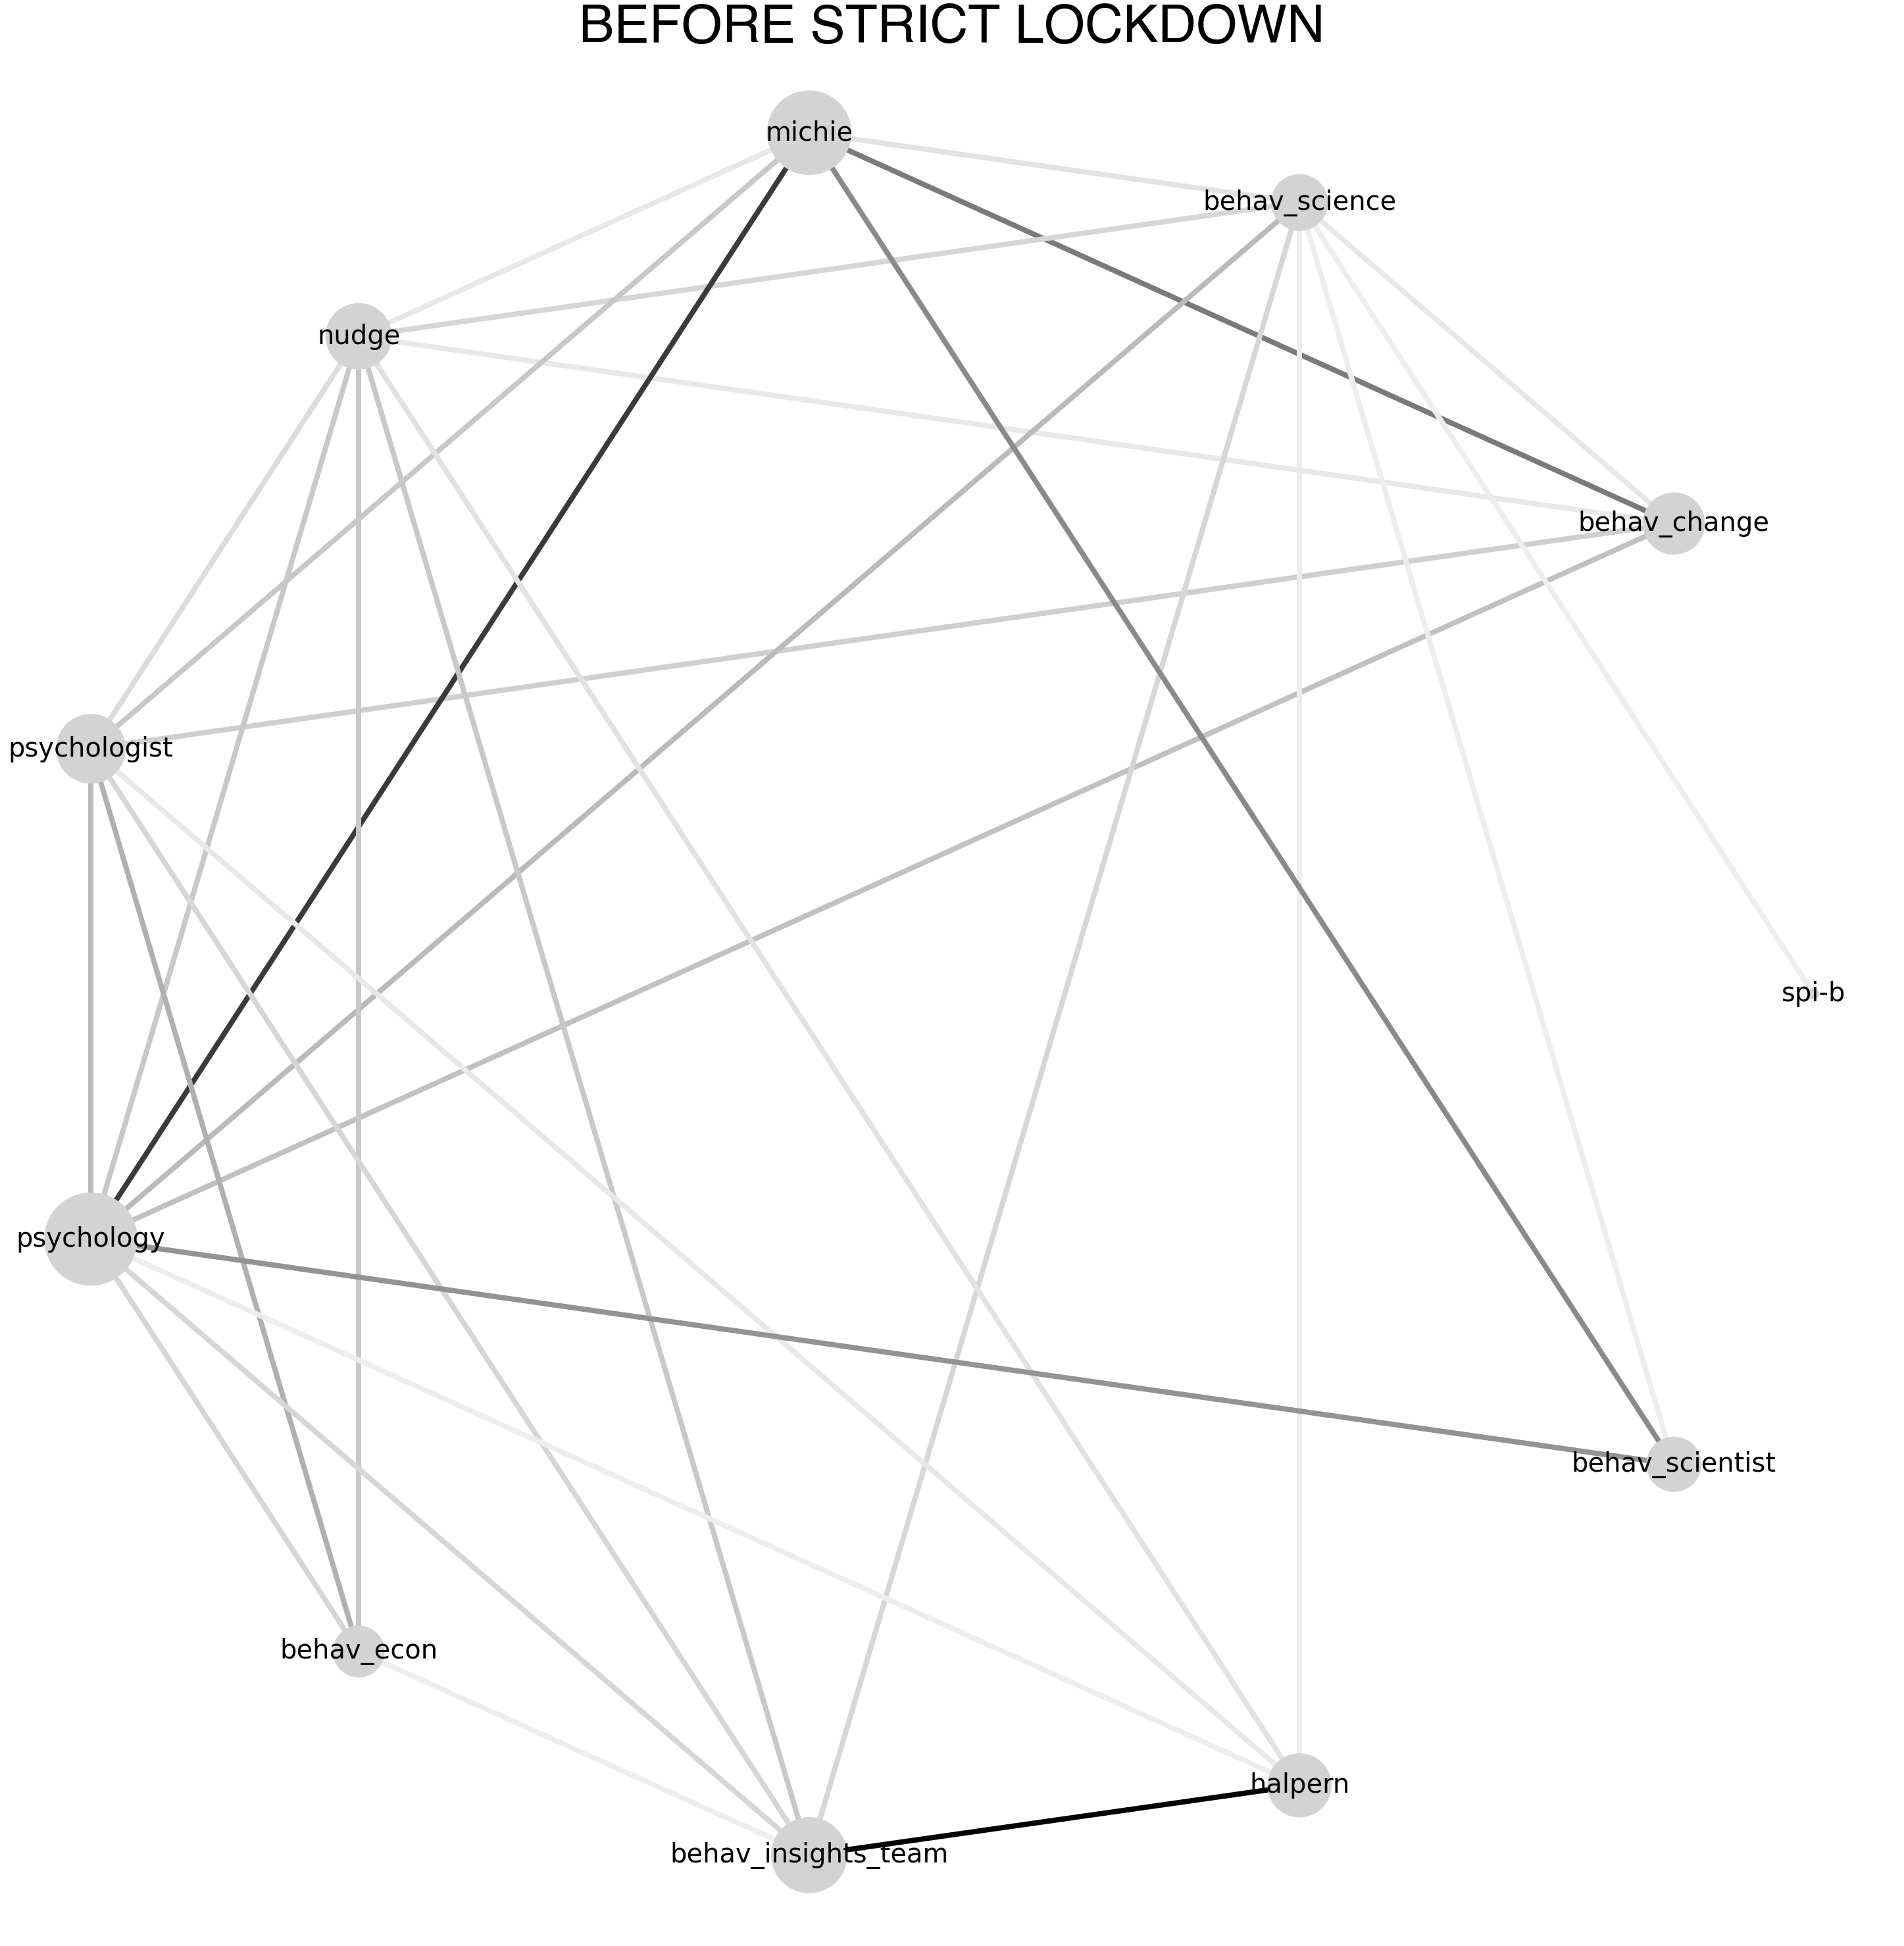

In [118]:
plt.figure(figsize = (40,40))

nx.draw(before_dice_graph, 
                 pos=alphapos,
                 with_labels=True, 
                 edge_color=before_dice_graph_weights,
                 width=8,
                 node_color='lightgray',
        linewidths=1,
        node_size=[v * 10000 for v in before_dice_graph_degrees.values()],
                 font_size=40,
                font_type="Helvetica",
                 font_color='black',
                 font_weight=3,
                 edge_cmap=newCmap,
                edge_vmin=0
                )

plt.title("Before strict lockdown".upper(), fontsize=80, **csfont)
plt.axis('off')
 
#plt.savefig('output.png')
plt.show()

### During lockdown

In [119]:
# drop NaN cases and 0.0 values
lock_dice_coefs.dropna(inplace=True)

In [120]:
lock_dice_coefs = lock_dice_coefs[lock_dice_coefs.lock_weight > 0.0]

In [121]:
lock_dice_graph = nx.from_pandas_edgelist(lock_dice_coefs[['source', 'target', 'lock_weight']], edge_attr=True)

In [122]:
# check nodes
sorted(lock_dice_graph.nodes)

['behav_change',
 'behav_econ',
 'behav_insights_team',
 'behav_science',
 'behav_scientist',
 'halpern',
 'michie',
 'nudge',
 'psychologist',
 'psychology',
 'spi-b']

In [123]:
sorted(before_dice_graph.nodes)

['behav_change',
 'behav_econ',
 'behav_insights_team',
 'behav_science',
 'behav_scientist',
 'halpern',
 'michie',
 'nudge',
 'psychologist',
 'psychology',
 'spi-b']

In [124]:
# take a look at one
print(nx.to_dict_of_dicts(lock_dice_graph).get('michie'))

{'behav_change': {'lock_weight': 0.5142857142857142}, 'behav_insights_team': {'lock_weight': 0.02631578947368421}, 'behav_science': {'lock_weight': 0.12359550561797752}, 'behav_scientist': {'lock_weight': 0.05}, 'halpern': {'lock_weight': 0.031746031746031744}, 'psychologist': {'lock_weight': 0.16216216216216217}, 'psychology': {'lock_weight': 0.24242424242424243}, 'spi-b': {'lock_weight': 0.07407407407407407}}


In [125]:
# extract weights, we'll use them for plotting
lock_dice_weights = list(nx.get_edge_attributes(lock_dice_graph,'lock_weight').values())

In [126]:
# calculate nodes' degree to use as node size
lock_dice_graph_degrees = dict(nx.degree(lock_dice_graph, weight='lock_weight'))
lock_dice_graph_degrees

{'behav_change': 1.10824503816985,
 'behav_insights_team': 1.5147041434534363,
 'behav_science': 1.436357485752651,
 'behav_scientist': 0.6551081388162087,
 'halpern': 1.381167087567133,
 'michie': 1.2246035197838863,
 'nudge': 1.2617920837802963,
 'psychologist': 1.3385513723811322,
 'psychology': 1.6190329370964078,
 'spi-b': 0.593680615931554,
 'behav_econ': 0.5216780675487003}

In [127]:
lvTmp2 = np.linspace(0.11,1.0,len(lock_dice_weights)-1)
lvTmp2


array([0.11      , 0.12934783, 0.14869565, 0.16804348, 0.1873913 ,
       0.20673913, 0.22608696, 0.24543478, 0.26478261, 0.28413043,
       0.30347826, 0.32282609, 0.34217391, 0.36152174, 0.38086957,
       0.40021739, 0.41956522, 0.43891304, 0.45826087, 0.4776087 ,
       0.49695652, 0.51630435, 0.53565217, 0.555     , 0.57434783,
       0.59369565, 0.61304348, 0.6323913 , 0.65173913, 0.67108696,
       0.69043478, 0.70978261, 0.72913043, 0.74847826, 0.76782609,
       0.78717391, 0.80652174, 0.82586957, 0.84521739, 0.86456522,
       0.88391304, 0.90326087, 0.9226087 , 0.94195652, 0.96130435,
       0.98065217, 1.        ])

In [128]:
cmTmp2 = plt.cm.Greys(lvTmp2)
newCmap2 = mcol.ListedColormap(cmTmp2)

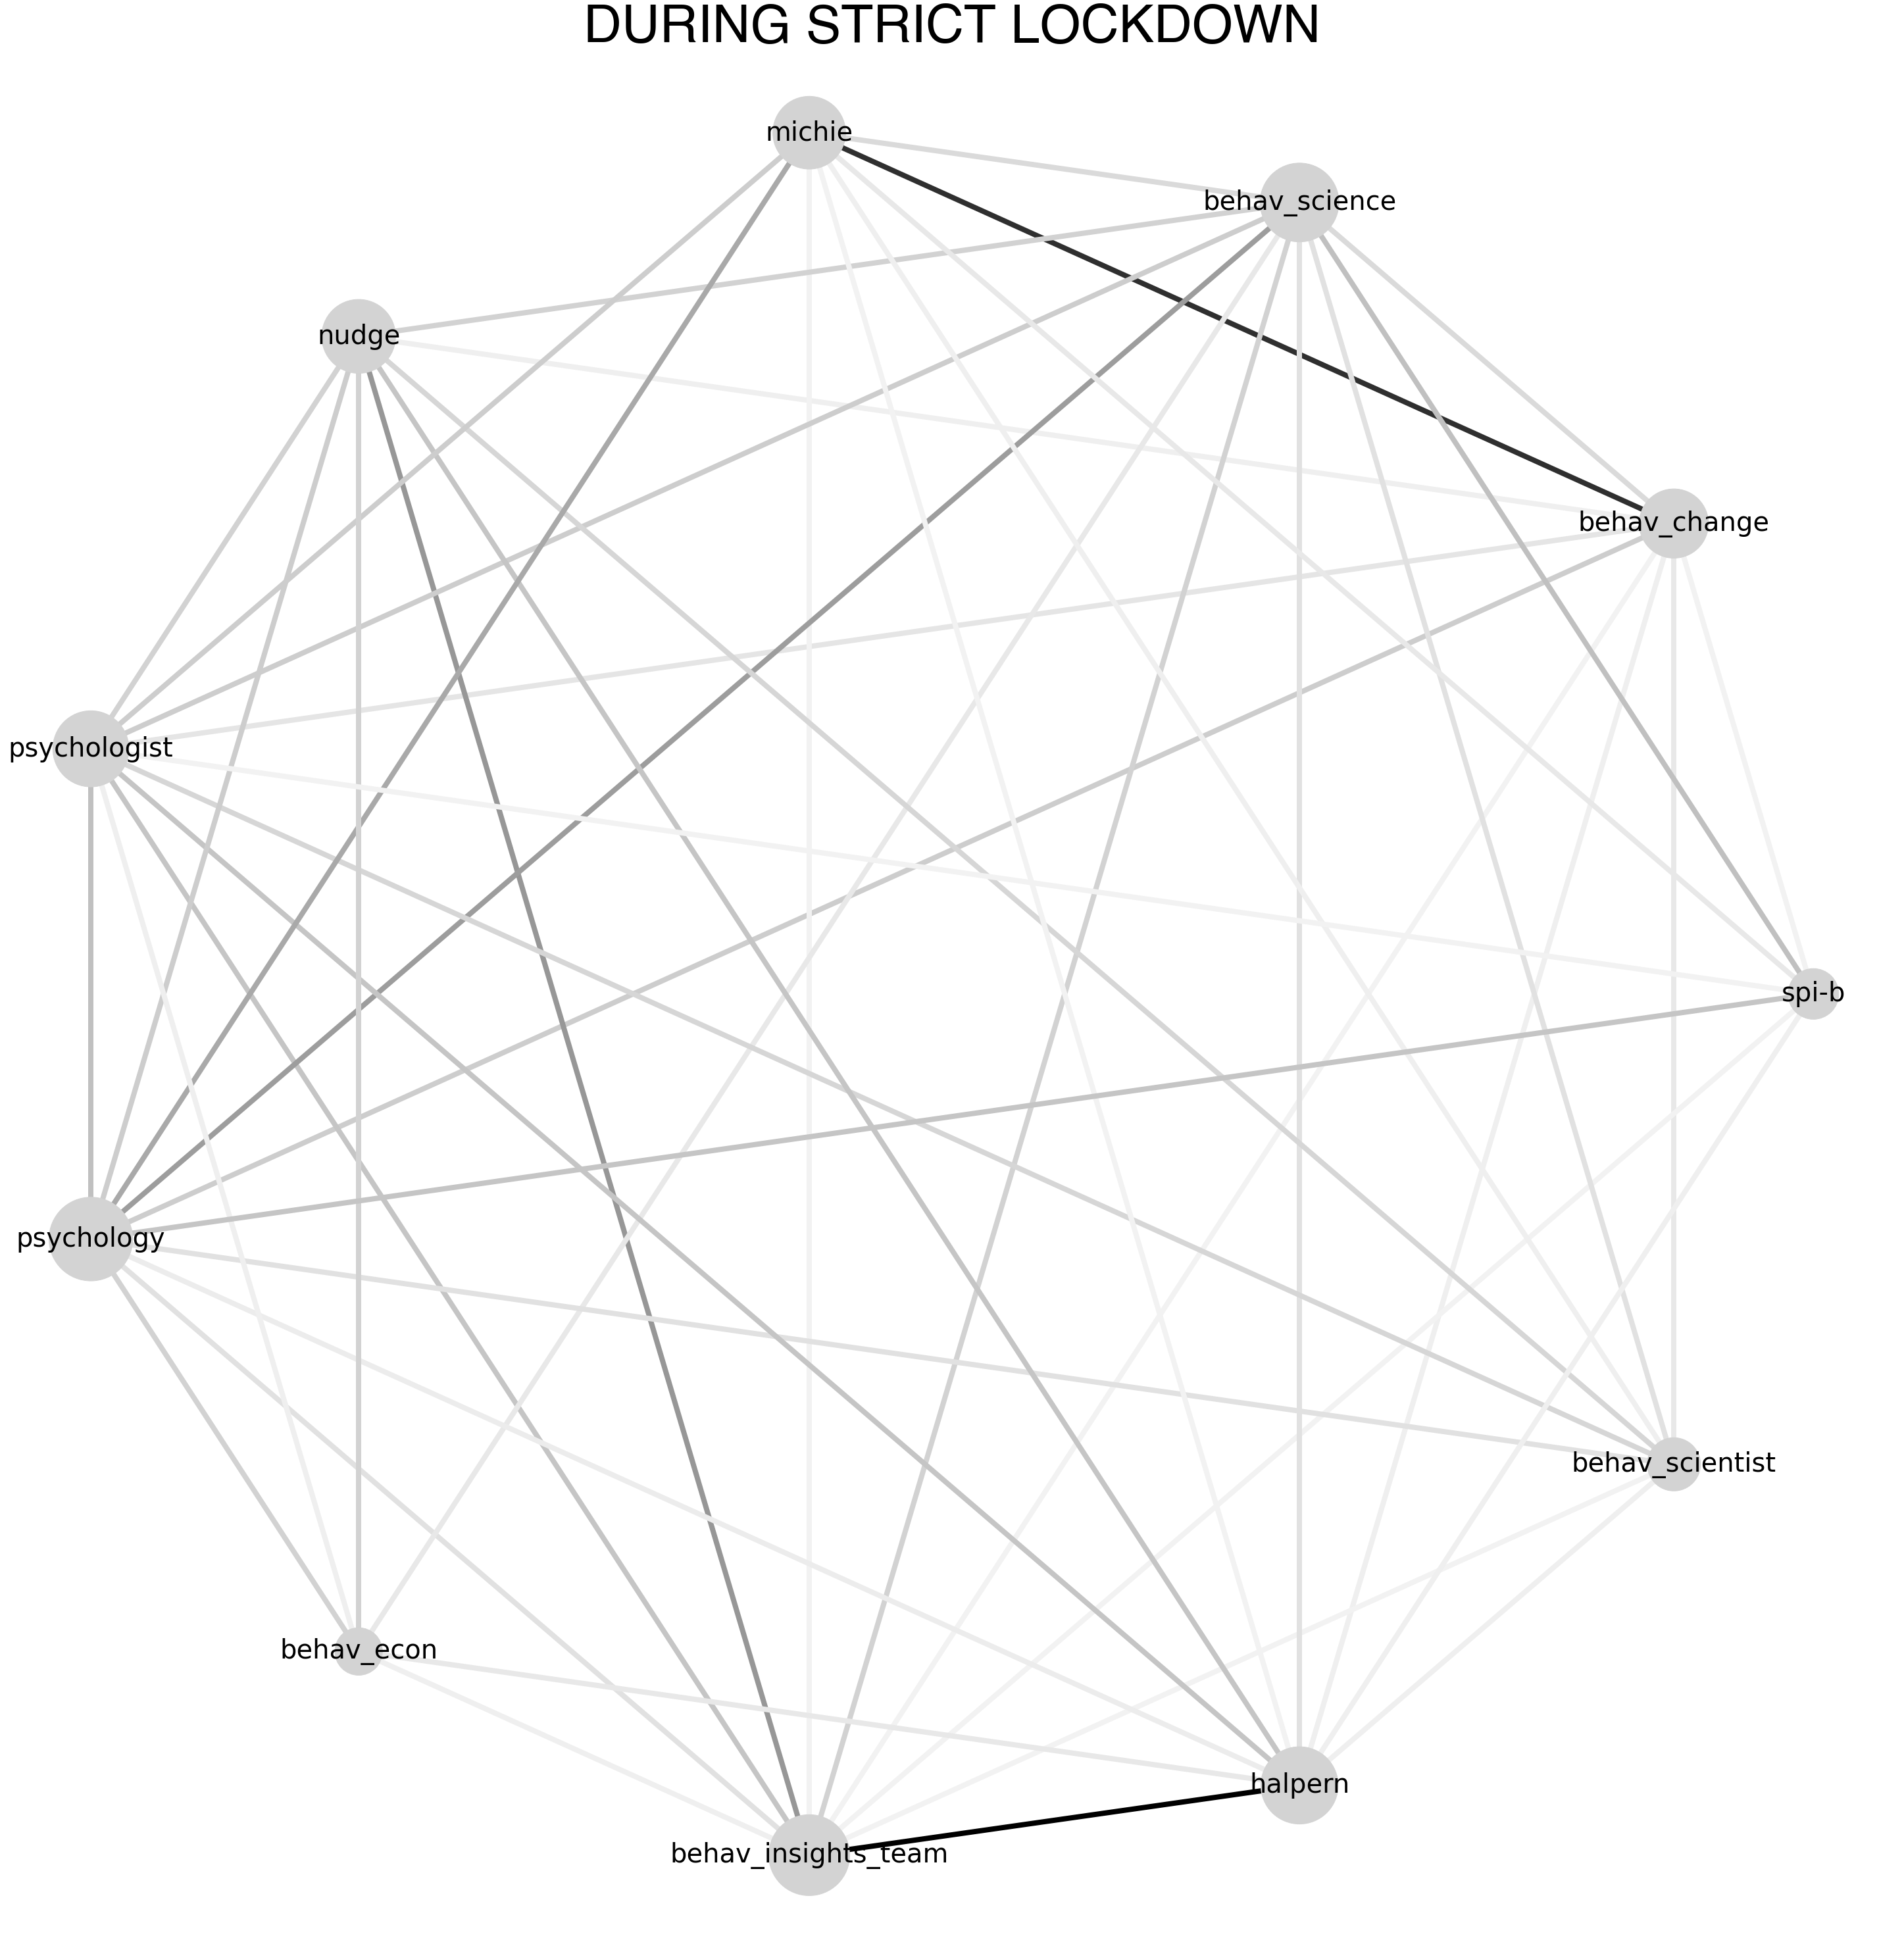

In [129]:
#fig, ax = plt.subplots(figsize=(40,40))  
plt.figure(figsize = (40,40))

nx.draw(lock_dice_graph, 
        pos=alphapos,
                 with_labels=True, 
                 edge_color=lock_dice_weights,
                 width=8,
                 node_color='lightgrey',
        linewidths=1,
        node_size=[v * 10000 for v in lock_dice_graph_degrees.values()],
                 font_size=40,
        font_type="Helvetica",
                 font_color='black',
                 font_weight=3,
                 edge_cmap=newCmap2 #plt.cm.Blues
                )

plt.title("During strict lockdown".upper(), fontsize=80, **csfont)
plt.axis('off')
 
#plt.savefig('output.png')
plt.show()

## After strict lockdown

In [130]:
post_dice_coefs.dropna(inplace=True)

In [131]:
post_dice_coefs = post_dice_coefs[post_dice_coefs.post_weight > 0.0]

In [132]:
post_dice_graph = nx.from_pandas_edgelist(post_dice_coefs[['source', 'target', 'post_weight']], edge_attr=True)

In [133]:
# take a look at one
print(nx.to_dict_of_dicts(post_dice_graph).get('michie'))

{'behav_change': {'post_weight': 0.46875}, 'behav_science': {'post_weight': 0.21686746987951808}, 'behav_scientist': {'post_weight': 0.14285714285714285}, 'psychologist': {'post_weight': 0.24}, 'psychology': {'post_weight': 0.3516483516483517}, 'spi-b': {'post_weight': 0.1702127659574468}}


In [134]:
# extract weights, we'll use them for plotting
post_dice_weights = list(nx.get_edge_attributes(post_dice_graph,'post_weight').values())

In [135]:
# calculate nodes' degree to use as node size
post_dice_graph_degrees = dict(nx.degree(post_dice_graph, weight='post_weight'))
post_dice_graph_degrees

{'behav_change': 1.1612669538776728,
 'behav_science': 1.2275820954745726,
 'behav_scientist': 0.9501370035373793,
 'michie': 1.5903357303424595,
 'psychologist': 1.1991702681243928,
 'psychology': 1.7412132481537979,
 'spi-b': 1.0757507424521986,
 'behav_econ': 0.07547169811320754,
 'behav_insights_team': 0.9872251536358275,
 'halpern': 0.951903341981954,
 'nudge': 0.8990632246724524}

In [136]:
lvTmp3 = np.linspace(0.11,1.0,len(post_dice_weights)-1)
lvTmp3
cmTmp3 = plt.cm.Greys(lvTmp3)
newCmap3 = mcol.ListedColormap(cmTmp3)

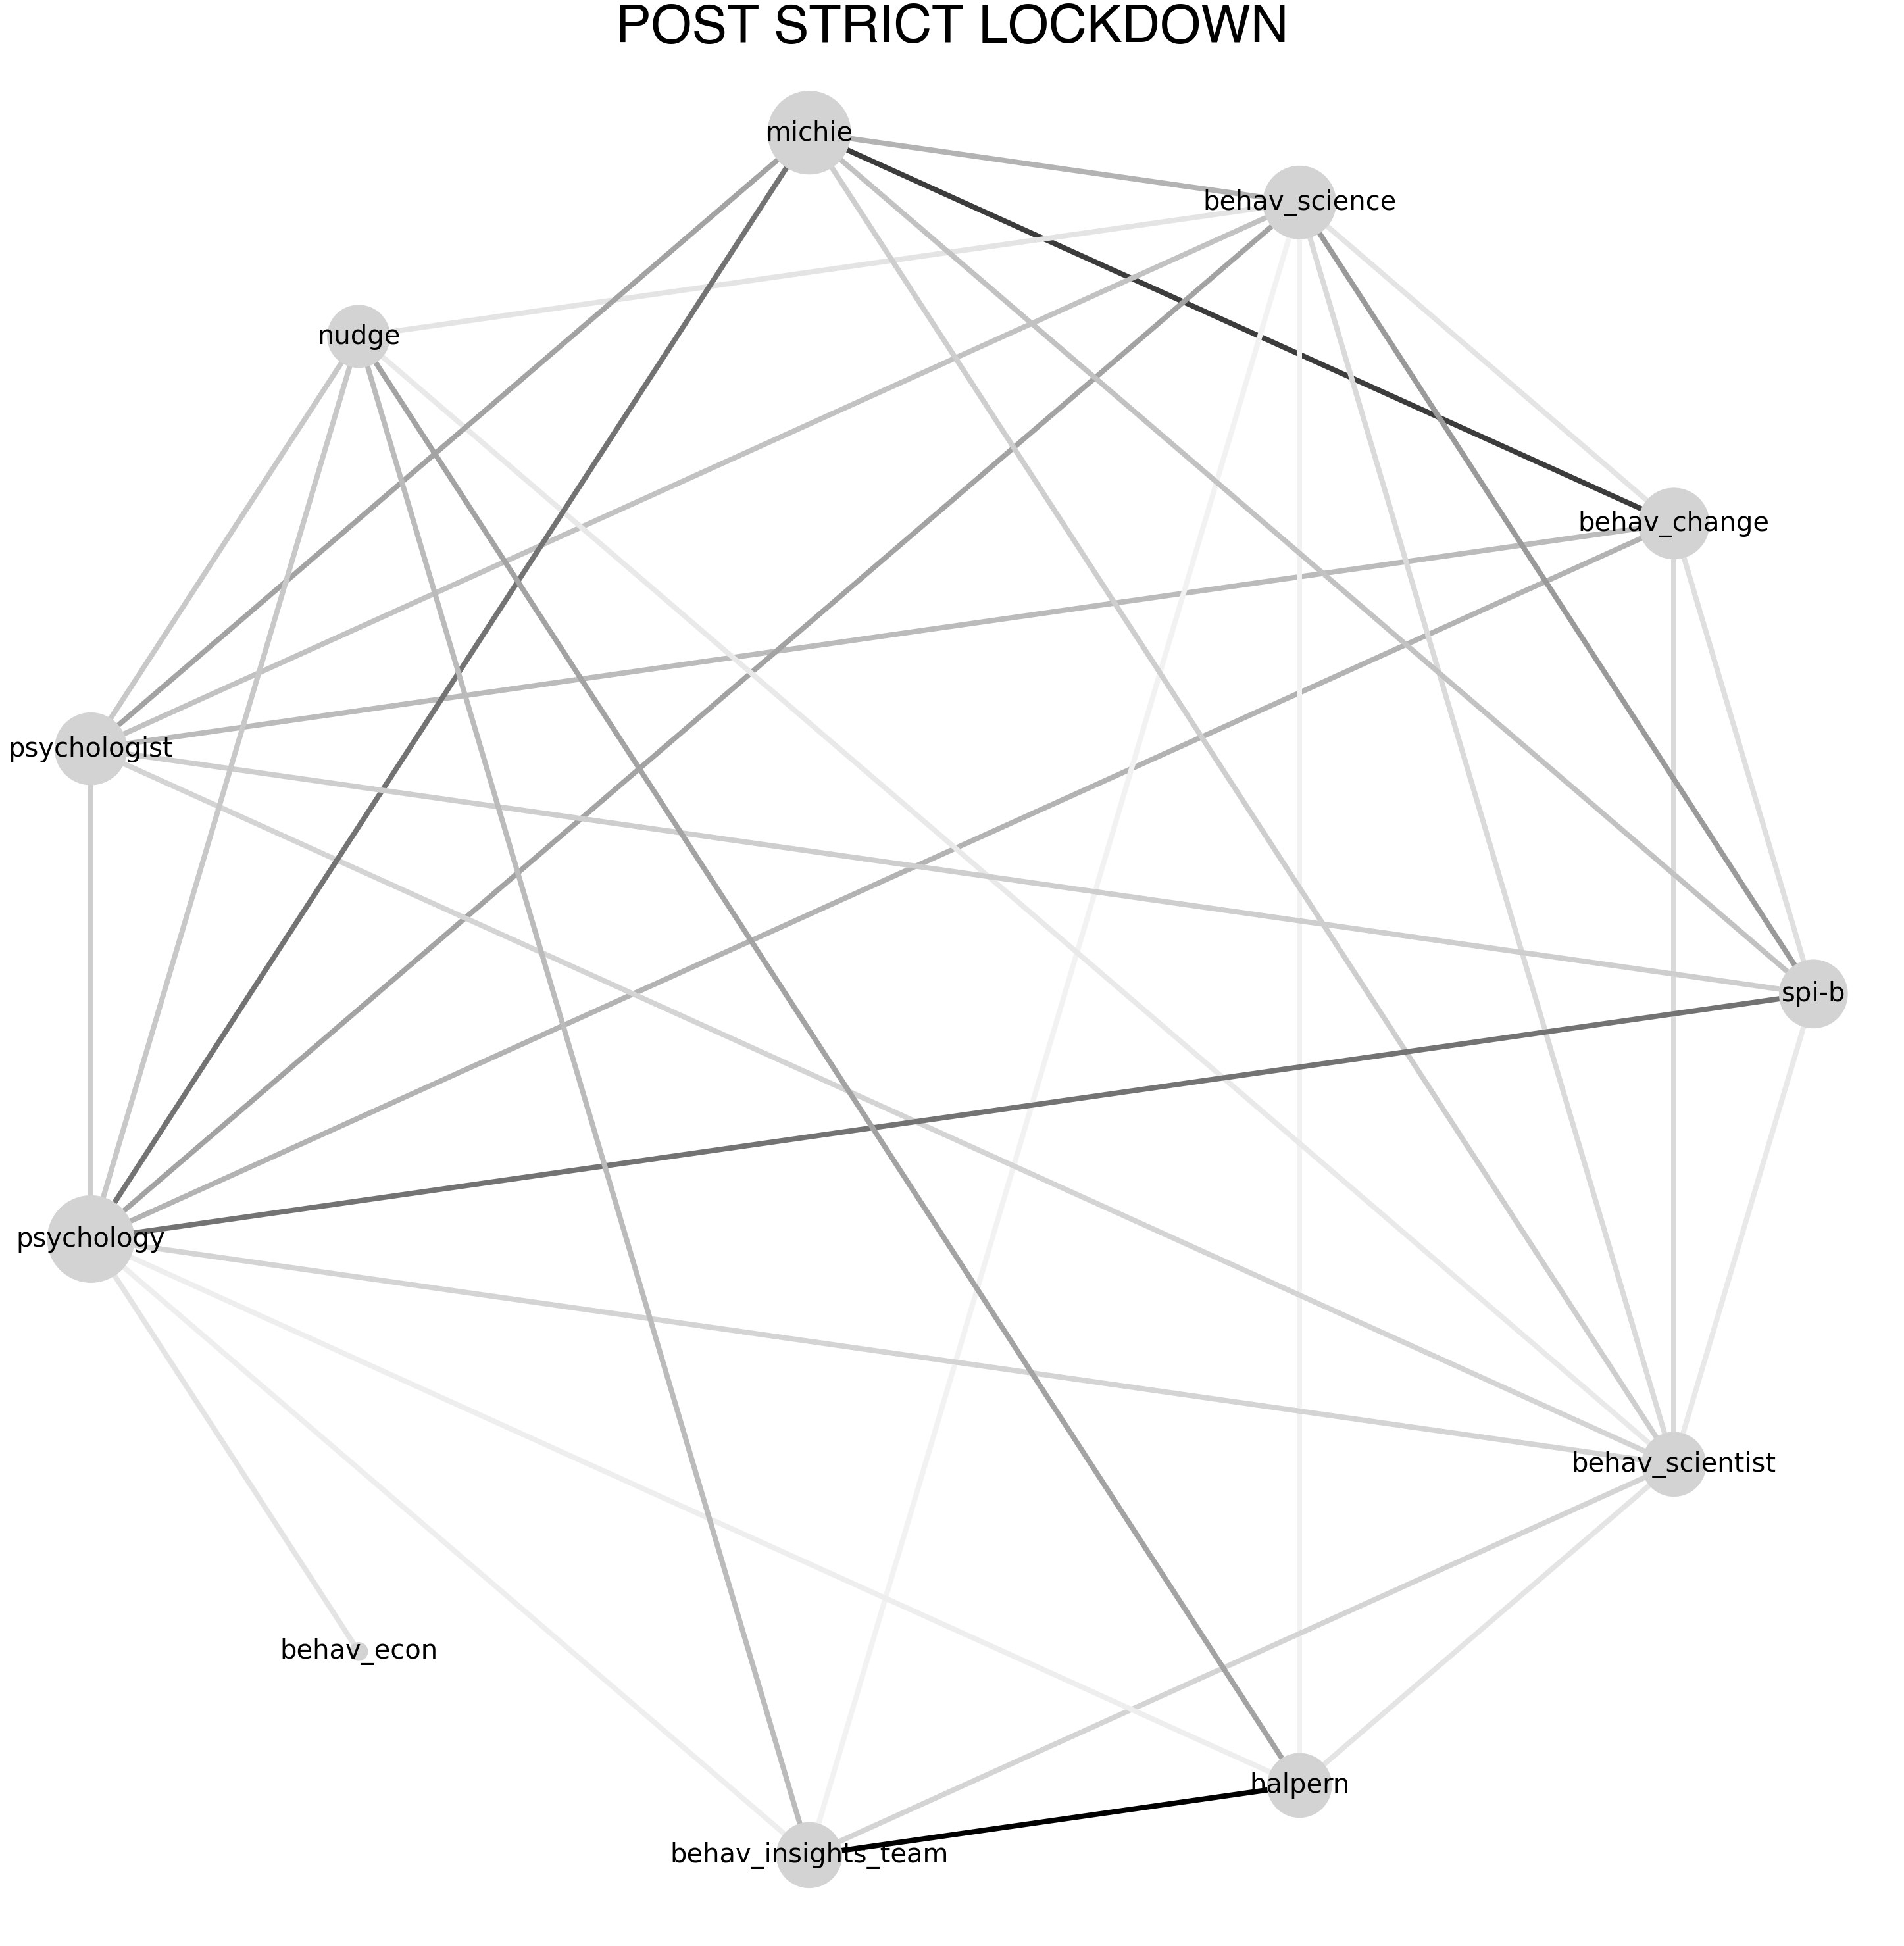

In [137]:
plt.figure(figsize = (40,40))

nx.draw(post_dice_graph, 
        pos=alphapos,
                 with_labels=True, 
                 edge_color=post_dice_weights,
                 width=8,
                 node_color='lightgrey',
        linewidths=1,
        node_size=[v * 10000 for v in post_dice_graph_degrees.values()],
                 font_size=40,
        font_type="Helvetica",
                 font_color='black',
                 font_weight=3,
                 edge_cmap=newCmap3
                )

plt.title("Post strict lockdown".upper(), fontsize=80, **csfont)
plt.axis('off')
 
#plt.savefig('output.png')
plt.show()

## Characteristics of the three networks and nodes

Main ref: https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

### Number of nodes (keywords that co-occured)

In [138]:
print("Number of keywords co-occurring before-lockdown:", len(before_dice_graph.nodes))

Number of keywords co-occurring before-lockdown: 11


In [139]:
print("Number of keywords co-occurring during-lockdown:", len(lock_dice_graph.nodes))

Number of keywords co-occurring during-lockdown: 11


In [140]:
print("Number of keywords co-occurring post-lockdown:", len(post_dice_graph.nodes))

Number of keywords co-occurring post-lockdown: 11


### Network density

Network density
= ratio between actual number of connections between nodes and maximum possible number of connections.

Give a sense of how closely knit the network is, a higher value (within [0,1]) indicates a more cohesive network, so a set of keywords that do tend to co-occur.



In [141]:
before_density = nx.density(before_dice_graph)
print("Network density (before lockdown):", before_density)

Network density (before lockdown): 0.5636363636363636


In [142]:
lock_density = nx.density(lock_dice_graph)
print("Network density (during lockdown):", lock_density)

Network density (during lockdown): 0.8727272727272727


In [143]:
post_density = nx.density(post_dice_graph)
print("Network density (post lockdown):", post_density)

Network density (post lockdown): 0.6363636363636364


- Network density has increased during lockdown compared to pre-lockdown. 
    Interpretation: an increase in the general tendency of keywords to co-occur together in the same documents. 
    
- Network density decreased post lockdown compared to lockdown but remained higher than during pre-lockdown period.

### Network Clustering Coefficient

= n^ of connections between the neighbour nodes of a node / maximum possible number of connections between its neighbour nodes

(neighbour nodes are the nodes directly connected to a node).

A measure of the degree to which nodes in a graph tend to cluster together.

In [144]:
before_clustcoef = nx.average_clustering(before_dice_graph, weight='bef_weights')
print("Network clustering coefficient (before lockdown):", before_clustcoef)

Network clustering coefficient (before lockdown): 0.7023809523809524


In [145]:
lock_clustcoef = nx.average_clustering(lock_dice_graph, weight='lock_weights')
print("Network clustering coefficient (during lockdown):", lock_clustcoef)

Network clustering coefficient (during lockdown): 0.9087301587301588


In [146]:
post_clustcoef = nx.average_clustering(post_dice_graph, weight='lock_weights')
print("Network clustering coefficient (during lockdown):", post_clustcoef)

Network clustering coefficient (during lockdown): 0.788023088023088


Increased during lockdown and remained higher than pre-lockdown also in the post-lockdown period. 

## Centrality measures

Identify nodes (keywords) that are more important in the networks and compare the ranking them over time.

### Node Degree

The number of connection a node has. For a weighted network, this is the sum of the edge weights adjacent to the node. 

Here is with how many different keywords does each keyword co-occur?
Note that this is likely to be proportional to the keyword's frequency. Something we can also report.

In [147]:
def get_node_degree(graph, weight=None):
    node_degree_dict = {}
    for node in graph.nodes:
        node_degree_dict[node] = nx.degree(graph, node, weight)
    return node_degree_dict    

Before lockdown

In [148]:
before_node_degrees = pd.Series(get_node_degree(before_dice_graph, weight='bef_weight')).sort_values(ascending=False)
print(before_node_degrees)

psychology             1.980195
michie                 1.626003
behav_insights_team    1.316835
psychologist           1.096815
nudge                  0.997600
halpern                0.928954
behav_change           0.875443
behav_science          0.729050
behav_scientist        0.688084
behav_econ             0.604167
spi-b                  0.026667
dtype: float64


During lockdown

In [149]:
lock_node_degrees = pd.Series(get_node_degree(lock_dice_graph, weight='lock_weight')).sort_values(ascending=False)
print(lock_node_degrees)

psychology             1.619033
behav_insights_team    1.514704
behav_science          1.436357
halpern                1.381167
psychologist           1.338551
nudge                  1.261792
michie                 1.224604
behav_change           1.108245
behav_scientist        0.655108
spi-b                  0.593681
behav_econ             0.521678
dtype: float64


Post lockdown

In [150]:
post_node_degrees = pd.Series(get_node_degree(post_dice_graph, weight='post_weight')).sort_values(ascending=False)
print(post_node_degrees)

psychology             1.741213
michie                 1.590336
behav_science          1.227582
psychologist           1.199170
behav_change           1.161267
spi-b                  1.075751
behav_insights_team    0.987225
halpern                0.951903
behav_scientist        0.950137
nudge                  0.899063
behav_econ             0.075472
dtype: float64


In [151]:
# alternative way to calculate it

In [152]:
before_degree_dict = dict(before_dice_graph.degree(before_dice_graph.nodes(), weight='bef_weight'))
nx.set_node_attributes(before_dice_graph, before_degree_dict, 'degree')

In [153]:
lock_degree_dict = dict(lock_dice_graph.degree(lock_dice_graph.nodes(), weight='lock_weight'))
nx.set_node_attributes(lock_dice_graph, lock_degree_dict, 'degree')

In [154]:
post_degree_dict = dict(post_dice_graph.degree(post_dice_graph.nodes(), weight='post_weight'))
nx.set_node_attributes(post_dice_graph, post_degree_dict, 'degree')

### Node Betweeness Centrality

Betweenness centrality doesn’t care about the number of edges any one node or set of nodes has. Betweenness centrality looks at all the shortest paths that pass through a particular node.

So a keyword with a high betweeness centrality is a keyword that works as a bridge by connecting several different other keywords - i.e., it is discussed in articles with a wider variety of other keywords.

https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html
for weighted networks

#### Pre-lockdown

In [155]:
before_betweenness_dict = nx.betweenness_centrality(
    before_dice_graph, 
    weight='bef_weights'
    ) 

# Assign each to an attribute in your network
nx.set_node_attributes(before_dice_graph, before_betweenness_dict, 'betweenness')


In [156]:
sorted(before_betweenness_dict.items(), key=itemgetter(1), reverse=True)

[('behav_science', 0.25925925925925924),
 ('psychology', 0.13518518518518519),
 ('nudge', 0.06481481481481481),
 ('psychologist', 0.04259259259259259),
 ('michie', 0.03333333333333333),
 ('behav_insights_team', 0.02777777777777778),
 ('behav_change', 0.007407407407407408),
 ('halpern', 0.007407407407407408),
 ('behav_econ', 0.0),
 ('behav_scientist', 0.0),
 ('spi-b', 0.0)]

Compare degree and between centrality

In [157]:
#Then find and print their degree
for tb in sorted(before_betweenness_dict.items(), key=itemgetter(1), reverse=True): 
    degree = before_degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: behav_science | Betweenness Centrality: 0.25925925925925924 | Degree: 0.7290500769425795
Name: psychology | Betweenness Centrality: 0.13518518518518519 | Degree: 1.980195063857661
Name: nudge | Betweenness Centrality: 0.06481481481481481 | Degree: 0.997599573794999
Name: psychologist | Betweenness Centrality: 0.04259259259259259 | Degree: 1.0968151924034277
Name: michie | Betweenness Centrality: 0.03333333333333333 | Degree: 1.6260033052602711
Name: behav_insights_team | Betweenness Centrality: 0.02777777777777778 | Degree: 1.3168350140124334
Name: behav_change | Betweenness Centrality: 0.007407407407407408 | Degree: 0.8754432500349016
Name: halpern | Betweenness Centrality: 0.007407407407407408 | Degree: 0.928953748443175
Name: behav_econ | Betweenness Centrality: 0.0 | Degree: 0.6041666666666667
Name: behav_scientist | Betweenness Centrality: 0.0 | Degree: 0.6880844645550528
Name: spi-b | Betweenness Centrality: 0.0 | Degree: 0.02666666666666667


#### During lockdown

In [158]:
lock_betweenness_dict = nx.betweenness_centrality(
    lock_dice_graph,
    weight='lock_weights') 

# Assign each to an attribute in your network
nx.set_node_attributes(lock_dice_graph, lock_betweenness_dict, 'betweenness')


sorted(lock_betweenness_dict.items(), key=itemgetter(1), reverse=True)

[('behav_insights_team', 0.02634920634920635),
 ('behav_science', 0.02634920634920635),
 ('halpern', 0.02634920634920635),
 ('psychologist', 0.02634920634920635),
 ('psychology', 0.02634920634920635),
 ('behav_change', 0.010052910052910053),
 ('nudge', 0.007407407407407408),
 ('behav_scientist', 0.0031746031746031746),
 ('michie', 0.0031746031746031746),
 ('spi-b', 0.0),
 ('behav_econ', 0.0)]

Compare degree and between centrality

In [159]:
for tb in sorted(lock_betweenness_dict.items(), key=itemgetter(1), reverse=True): 
    degree = lock_degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: behav_insights_team | Betweenness Centrality: 0.02634920634920635 | Degree: 1.5147041434534363
Name: behav_science | Betweenness Centrality: 0.02634920634920635 | Degree: 1.436357485752651
Name: halpern | Betweenness Centrality: 0.02634920634920635 | Degree: 1.381167087567133
Name: psychologist | Betweenness Centrality: 0.02634920634920635 | Degree: 1.3385513723811322
Name: psychology | Betweenness Centrality: 0.02634920634920635 | Degree: 1.6190329370964078
Name: behav_change | Betweenness Centrality: 0.010052910052910053 | Degree: 1.10824503816985
Name: nudge | Betweenness Centrality: 0.007407407407407408 | Degree: 1.2617920837802963
Name: behav_scientist | Betweenness Centrality: 0.0031746031746031746 | Degree: 0.6551081388162087
Name: michie | Betweenness Centrality: 0.0031746031746031746 | Degree: 1.2246035197838863
Name: spi-b | Betweenness Centrality: 0.0 | Degree: 0.593680615931554
Name: behav_econ | Betweenness Centrality: 0.0 | Degree: 0.5216780675487003


#### Post lockdown

In [160]:
post_betweenness_dict = nx.betweenness_centrality(
    post_dice_graph,
    weight='post_weights'
) 

# Assign each to an attribute in your network
nx.set_node_attributes(post_dice_graph, post_betweenness_dict, 'betweenness')


sorted(post_betweenness_dict.items(), key=itemgetter(1), reverse=True)

[('psychology', 0.27222222222222225),
 ('behav_science', 0.07222222222222222),
 ('behav_scientist', 0.07222222222222222),
 ('psychologist', 0.016666666666666666),
 ('nudge', 0.011111111111111112),
 ('behav_change', 0.0),
 ('michie', 0.0),
 ('spi-b', 0.0),
 ('behav_econ', 0.0),
 ('behav_insights_team', 0.0),
 ('halpern', 0.0)]

In [161]:
for tb in sorted(post_betweenness_dict.items(), key=itemgetter(1), reverse=True): 
    degree = post_degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: psychology | Betweenness Centrality: 0.27222222222222225 | Degree: 1.7412132481537979
Name: behav_science | Betweenness Centrality: 0.07222222222222222 | Degree: 1.2275820954745726
Name: behav_scientist | Betweenness Centrality: 0.07222222222222222 | Degree: 0.9501370035373793
Name: psychologist | Betweenness Centrality: 0.016666666666666666 | Degree: 1.1991702681243928
Name: nudge | Betweenness Centrality: 0.011111111111111112 | Degree: 0.8990632246724524
Name: behav_change | Betweenness Centrality: 0.0 | Degree: 1.1612669538776728
Name: michie | Betweenness Centrality: 0.0 | Degree: 1.5903357303424595
Name: spi-b | Betweenness Centrality: 0.0 | Degree: 1.0757507424521986
Name: behav_econ | Betweenness Centrality: 0.0 | Degree: 0.07547169811320754
Name: behav_insights_team | Betweenness Centrality: 0.0 | Degree: 0.9872251536358275
Name: halpern | Betweenness Centrality: 0.0 | Degree: 0.951903341981954


### Communities of keywords based on modualarity

In [162]:
from networkx.algorithms import community

In [163]:
before_c = list(community.greedy_modularity_communities(before_dice_graph))

In [164]:
before_c

[frozenset({'behav_econ',
            'behav_insights_team',
            'halpern',
            'nudge',
            'psychologist',
            'psychology'}),
 frozenset({'behav_change',
            'behav_science',
            'behav_scientist',
            'michie',
            'spi-b'})]

In [165]:
during_lock_c = list(community.greedy_modularity_communities(lock_dice_graph))

In [166]:
during_lock_c

[frozenset({'behav_change',
            'behav_econ',
            'behav_insights_team',
            'behav_science',
            'behav_scientist',
            'halpern',
            'michie',
            'nudge',
            'psychologist',
            'psychology',
            'spi-b'})]

In [167]:
post_c = list(community.greedy_modularity_communities(post_dice_graph))

In [168]:
post_c

[frozenset({'behav_change',
            'behav_econ',
            'michie',
            'psychologist',
            'psychology',
            'spi-b'}),
 frozenset({'behav_insights_team',
            'behav_science',
            'behav_scientist',
            'halpern',
            'nudge'})]